In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


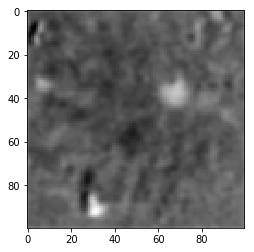

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'fullSess03' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 100
MAX_EPOCHS = 1000
l1_coeff = 0.1
thr = 0.3 #threshold for one hot pixel* sim score
dr = 0.4 #dropout rate
pre_pad_type = "SYMMETRIC"
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()   
    break
    

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


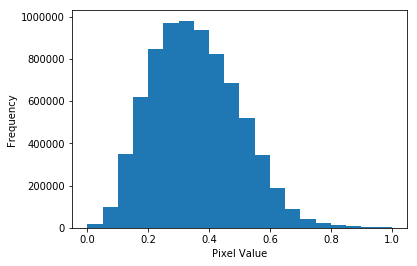

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#reshape
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[100 1 1 2]


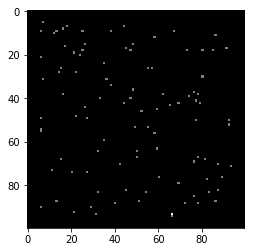

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size, pre_pad_type):
    #activity_regularizer=l1(0.1)
    #conv block1
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord=tf.pad(inps, paddings, pre_pad_type)
    coord1 =CoordConv(x_dim = 102, y_dim = 102, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='valid')(coord)
    
    paddings1 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])    
    coord1=tf.pad(coord1, paddings1, pre_pad_type)
    conv1=Conv2D(32, kernel_size = 3,strides=(2,2), padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coord1)
    conv2=Conv2D(32, kernel_size = 3,strides=(2,2), padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coord1)
    pool1=tf.keras.layers.Concatenate()([conv1, conv2])
    drop01 = Dropout(0.4)(pool1)
    paddingsp = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])    
    coordp=tf.pad(drop01, paddingsp, pre_pad_type)

    #conv block2
    conv3=Conv2D(32, kernel_size = 3,strides=(2,2), padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coordp)
    conv4=Conv2D(32, kernel_size = 3,strides=(2,2), padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coordp)
    pool2=tf.keras.layers.Concatenate()([conv3, conv4])
    drop02 = Dropout(0.4)(pool2)
    x = UpSampling2D(size=(2, 2),interpolation='bilinear')(drop02) 
    paddings2 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord2=tf.pad(x, paddings2, pre_pad_type)
    coord2 = Conv2D(32, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord2)
    coord2 = UpSampling2D(size=(2, 2),interpolation='bilinear')(coord2) 
    
    paddings3 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord3=tf.pad(coord2, paddings3, pre_pad_type)
    x3 = Conv2D(16, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord3)
    paddings4 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord4=tf.pad(x3, paddings4, pre_pad_type)
    output = Conv2D(1, 3, padding = 'valid', activation = 'sigmoid',activity_regularizer=l1(0.1))(coord4)
    
    return output



def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def de_conv02(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(coord01)
    f1 = Flatten()(conv01)
    output = Softmax(axis = -1)(f1)
    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return tf.cast(duplicate_imgs, dtype = tf.float32)

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
        #clip values so that the values doesnt runs out of the normalized pixel space 
        y = tf.clip_by_value(y, clip_value_min=0.0, clip_value_max=1.0) 
        return y

In [8]:
# def encoder02(inps, img_size):
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same',
#                        activity_regularizer=l1(l1_coeff))(inps)
#     leaky01 =tf.keras.layers.ReLU()(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", 
#                     activation = 'relu',activity_regularizer=l1(l1_coeff))(leaky01 )
#     leaky02 = tf.keras.layers.ReLU()(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', 
#                     padding='same',activity_regularizer=l1(l1_coeff))(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE, pre_pad_type))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
bxent = tf.keras.losses.BinaryCrossentropy()
msle = tf.keras.losses.MeanSquaredLogarithmicError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = False, one_hot_thr = False):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if neuron_multi==False:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = msle(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = msle(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        elif neuron_multi==True:
            #with thresholding 
            if one_hot_thr==True:
                #multiply similarity scores with one hot images
                #(batch_size, img_size, img_size, 1)
                similarity_multi_threshold = similarity_multi(one_hot_imgs, similarity_score, thr)
                similarity_multi_threshold_dummy = similarity_multi(dummy_one_hot, similarity_score, thr)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_threshold_dummy)
            #without thresholding
            elif one_hot_thr==False: 
                similarity_multi_reduced_neurons = similarity_multi(one_hot_imgs, similarity_score)
                similarity_multi_reduced_dummy = similarity_multi(dummy_one_hot, similarity_score)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #total global loss => global_loss + regularizer loss
        total_loss = global_loss + regularizer_loss
        #append loss 
        loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables
    grad_encoder = tape.gradient(encoded_one_loss, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(global_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     print(d)
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

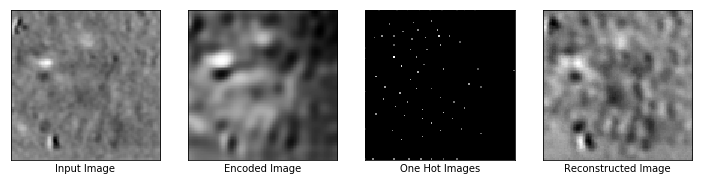

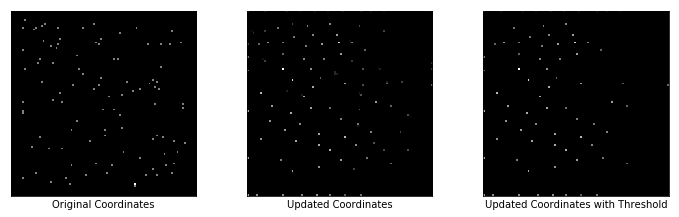

Epochs: 100, Session: 0
Reconstruction Loss: 0.001630804967135191
Regularizer Loss: 78476.453125, Total Loss: 78476.453125
Encoder Loss: 4.556467533111572
Max Similarity scores: 0.8682767152786255
Updated Coordinates: [[[0.44205216 0.75494105]]]
Gradient global min:-0.0014967978931963444, max:0.0012378459796309471
Gradient encoder min:-1.6278371810913086, max:1.6412345170974731
Gradient learnable coords min:-6.641581421718001e-05, max:1.9544591850717552e-05



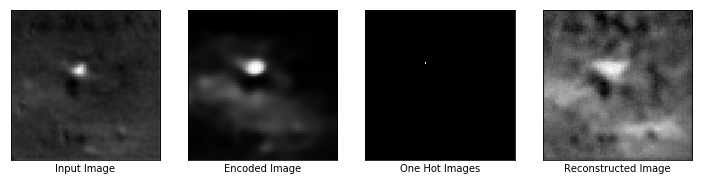

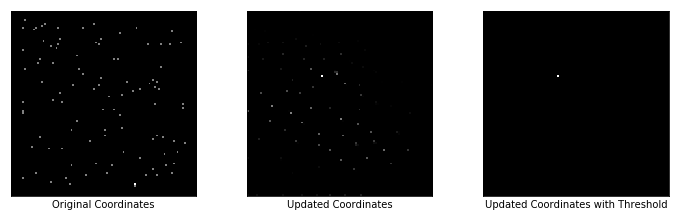

Epochs: 100, Session: 1
Reconstruction Loss: 0.0021169856190681458
Regularizer Loss: 64578.45703125, Total Loss: 64578.4609375
Encoder Loss: 0.9013082385063171
Max Similarity scores: 0.5771666169166565
Updated Coordinates: [[[0.44281983 0.7556694 ]]]
Gradient global min:-0.002051863120868802, max:0.0016212533228099346
Gradient encoder min:-0.3892050087451935, max:0.37667346000671387
Gradient learnable coords min:-0.00017350738926324993, max:9.576600132277235e-05



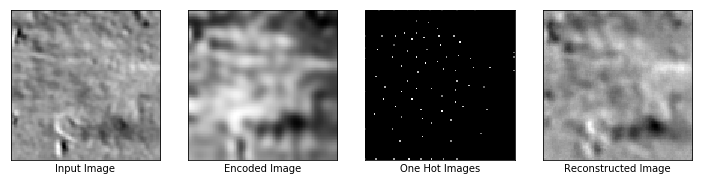

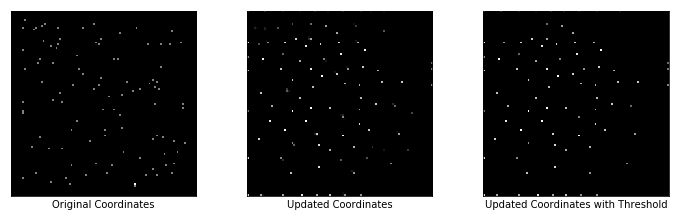

Epochs: 100, Session: 2
Reconstruction Loss: 0.0025305068120360374
Regularizer Loss: 93347.5625, Total Loss: 93347.5625
Encoder Loss: 7.926673412322998
Max Similarity scores: 0.854912281036377
Updated Coordinates: [[[0.44485214 0.7562947 ]]]
Gradient global min:-0.0010651526972651482, max:0.0009027732303366065
Gradient encoder min:-2.7045021057128906, max:2.7050929069519043
Gradient learnable coords min:-2.1077437850181013e-05, max:1.7241432942682877e-05



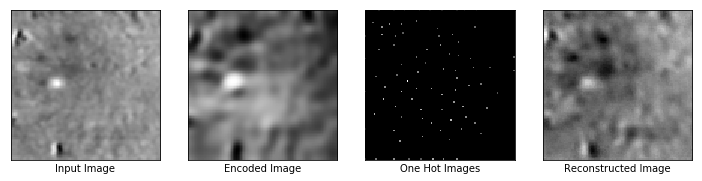

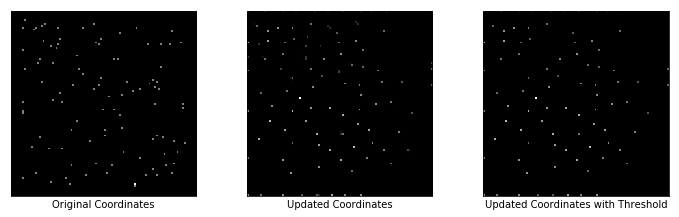

Epochs: 100, Session: 3
Reconstruction Loss: 0.001356951310299337
Regularizer Loss: 83324.375, Total Loss: 83324.375
Encoder Loss: 6.173363208770752
Max Similarity scores: 0.961024284362793
Updated Coordinates: [[[0.44368032 0.75914556]]]
Gradient global min:-0.0015451910439878702, max:0.0034808136988431215
Gradient encoder min:-2.178541898727417, max:2.2063772678375244
Gradient learnable coords min:-6.112335540819913e-05, max:2.6504099878366105e-05



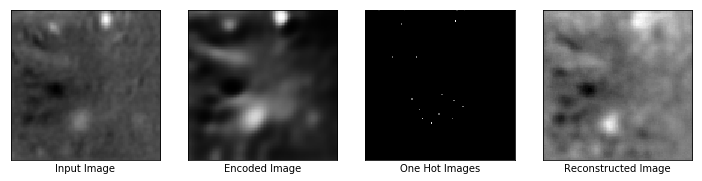

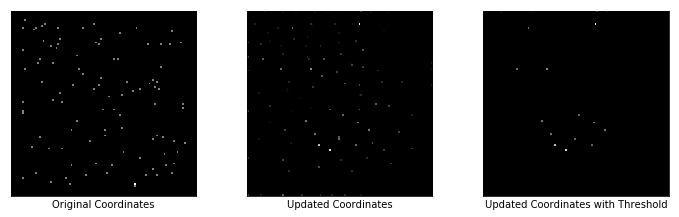

Epochs: 100, Session: 4
Reconstruction Loss: 0.0016341549344360828
Regularizer Loss: 75194.1484375, Total Loss: 75194.1484375
Encoder Loss: 3.9755380153656006
Max Similarity scores: 0.7803897261619568
Updated Coordinates: [[[0.44458917 0.75868493]]]
Gradient global min:-0.0007899947231635451, max:0.0008794863242655993
Gradient encoder min:-1.4029574394226074, max:1.416014313697815
Gradient learnable coords min:-5.3513635975832585e-06, max:9.691872037365101e-06



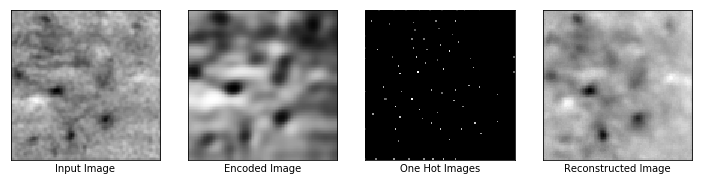

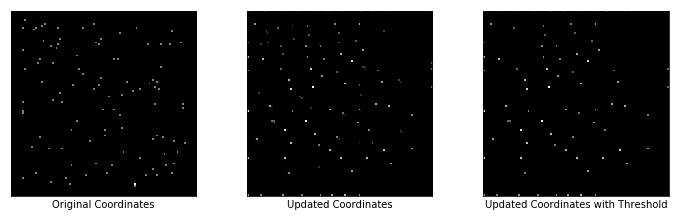

Epochs: 100, Session: 5
Reconstruction Loss: 0.0021511176601052284
Regularizer Loss: 91234.9921875, Total Loss: 91234.9921875
Encoder Loss: 7.172905445098877
Max Similarity scores: 0.9688023328781128
Updated Coordinates: [[[0.44426212 0.7588732 ]]]
Gradient global min:-0.0001423904177499935, max:0.0002858192892745137
Gradient encoder min:-2.601836919784546, max:2.54571270942688
Gradient learnable coords min:-1.0341457709728274e-05, max:4.270697172614746e-05



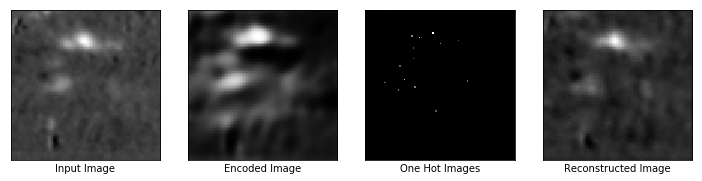

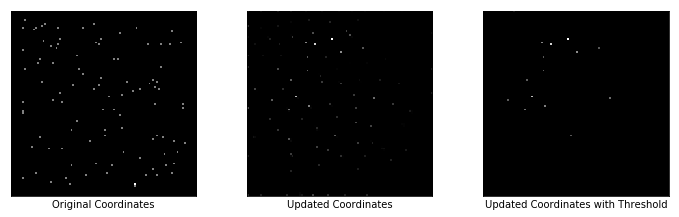

Epochs: 200, Session: 0
Reconstruction Loss: 0.0011631511151790619
Regularizer Loss: 98563.3203125, Total Loss: 98563.3203125
Encoder Loss: 4.326236724853516
Max Similarity scores: 0.9121442437171936
Updated Coordinates: [[[0.43193093 0.7566036 ]]]
Gradient global min:-0.0007808025111444294, max:0.0009872253285720944
Gradient encoder min:-1.5276609659194946, max:1.5355585813522339
Gradient learnable coords min:-1.2205210623505991e-05, max:1.620045986783225e-05



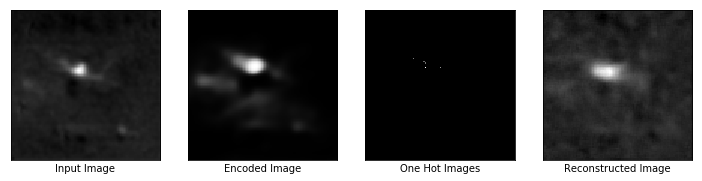

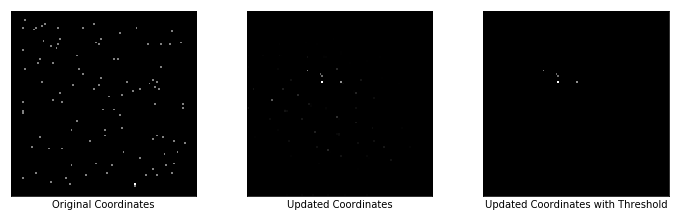

Epochs: 200, Session: 1
Reconstruction Loss: 0.0017610859358683228
Regularizer Loss: 91281.3828125, Total Loss: 91281.3828125
Encoder Loss: 0.8984404802322388
Max Similarity scores: 0.7977038025856018
Updated Coordinates: [[[0.43367717 0.7546413 ]]]
Gradient global min:-0.0002922092971857637, max:0.00026650045765563846
Gradient encoder min:-0.4541674554347992, max:0.4411052167415619
Gradient learnable coords min:-0.00029020418878644705, max:5.709633114747703e-05



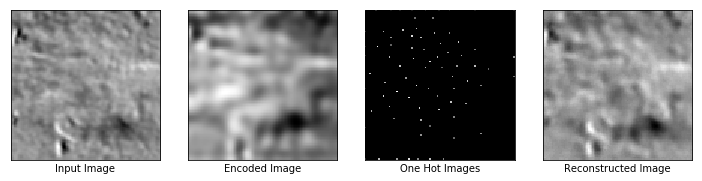

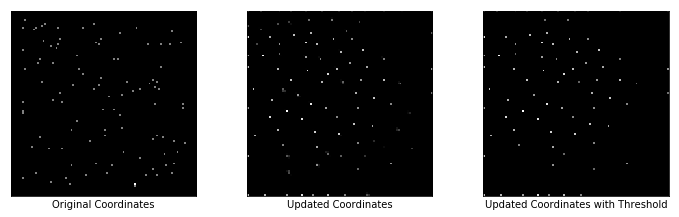

Epochs: 200, Session: 2
Reconstruction Loss: 0.0017746513476595283
Regularizer Loss: 109134.6640625, Total Loss: 109134.6640625
Encoder Loss: 7.659543514251709
Max Similarity scores: 0.8249632120132446
Updated Coordinates: [[[0.43018126 0.7704252 ]]]
Gradient global min:-0.0014592827064916492, max:0.006281090900301933
Gradient encoder min:-2.869340419769287, max:2.7597897052764893
Gradient learnable coords min:-6.147057138150558e-05, max:1.4467836081166752e-05



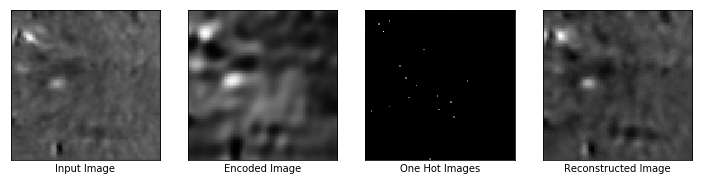

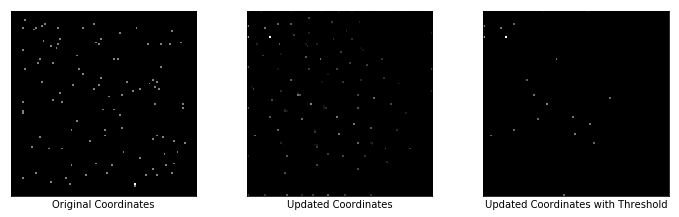

Epochs: 200, Session: 3
Reconstruction Loss: 0.000902657222468406
Regularizer Loss: 100066.984375, Total Loss: 100066.984375
Encoder Loss: 5.75229549407959
Max Similarity scores: 0.8421991467475891
Updated Coordinates: [[[0.4331206 0.7764554]]]
Gradient global min:-0.0016629684250801802, max:0.0012923855101689696
Gradient encoder min:-2.100450277328491, max:2.101977586746216
Gradient learnable coords min:-2.4896957256714813e-05, max:1.304150737269083e-05



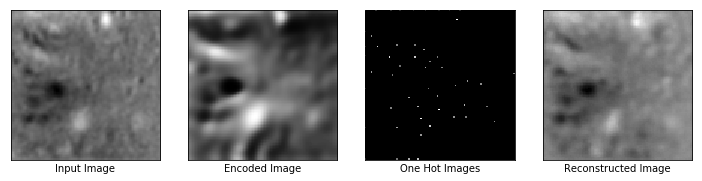

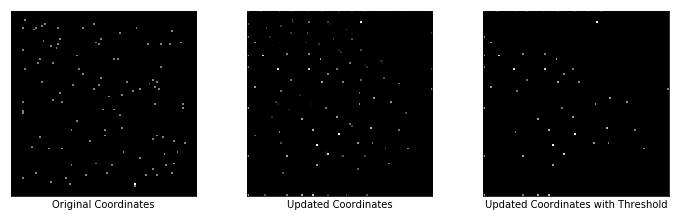

Epochs: 200, Session: 4
Reconstruction Loss: 0.0011697144946083426
Regularizer Loss: 95463.515625, Total Loss: 95463.515625
Encoder Loss: 3.705307722091675
Max Similarity scores: 0.7321141362190247
Updated Coordinates: [[[0.4301592 0.776771 ]]]
Gradient global min:-0.0009896295377984643, max:0.0010131420567631721
Gradient encoder min:-1.271327257156372, max:1.3227503299713135
Gradient learnable coords min:-1.0929071322607342e-05, max:1.0381736501585692e-05



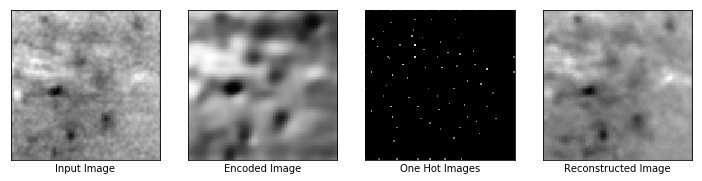

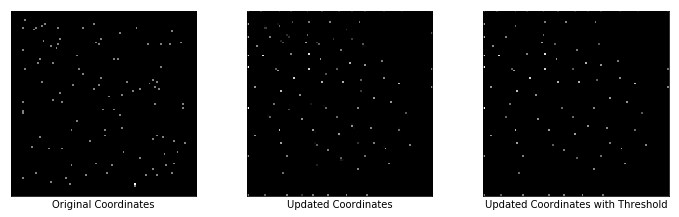

Epochs: 200, Session: 5
Reconstruction Loss: 0.0019981348887085915
Regularizer Loss: 107087.0546875, Total Loss: 107087.0546875
Encoder Loss: 6.761319160461426
Max Similarity scores: 0.9072830080986023
Updated Coordinates: [[[0.43274346 0.754594  ]]]
Gradient global min:-0.0004957954515703022, max:0.0008551543578505516
Gradient encoder min:-2.62695574760437, max:2.5539848804473877
Gradient learnable coords min:-8.743915714148898e-06, max:8.997759323392529e-06



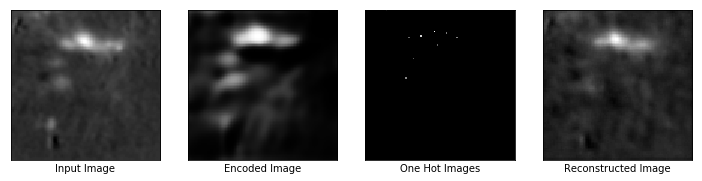

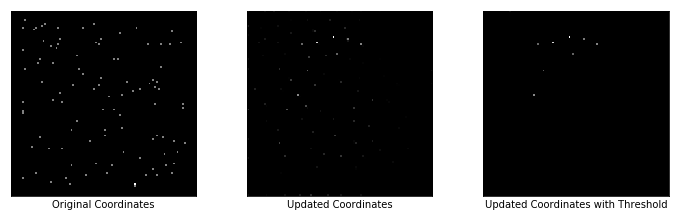

Epochs: 300, Session: 0
Reconstruction Loss: 0.001066127442754805
Regularizer Loss: 113184.2578125, Total Loss: 113184.2578125
Encoder Loss: 3.9630773067474365
Max Similarity scores: 0.8953431844711304
Updated Coordinates: [[[0.41193596 0.7764284 ]]]
Gradient global min:-0.00039447518065571785, max:0.0003776724333874881
Gradient encoder min:-0.9579501152038574, max:1.2345808744430542
Gradient learnable coords min:-5.275194416753948e-05, max:4.586914292303845e-05



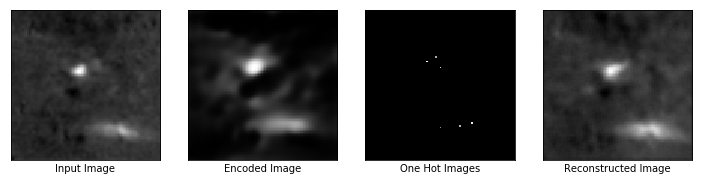

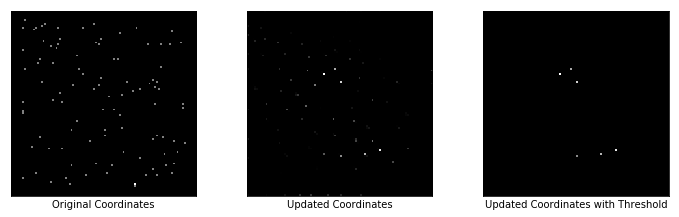

Epochs: 300, Session: 1
Reconstruction Loss: 0.0011222847970202565
Regularizer Loss: 111529.1640625, Total Loss: 111529.1640625
Encoder Loss: 0.8493722677230835
Max Similarity scores: 0.6523351669311523
Updated Coordinates: [[[0.41286263 0.77563876]]]
Gradient global min:-0.00019365421030670404, max:0.0003629098937381059
Gradient encoder min:-0.4139920473098755, max:0.4316467344760895
Gradient learnable coords min:-6.4154128267546184e-06, max:9.671073712524958e-06



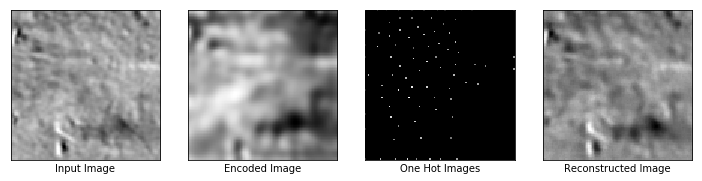

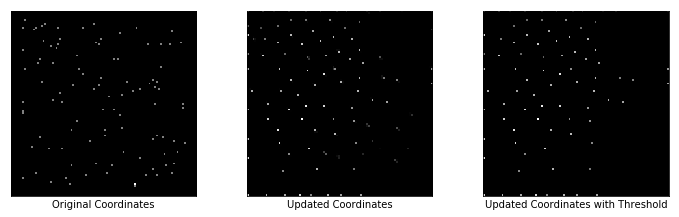

Epochs: 300, Session: 2
Reconstruction Loss: 0.001395267783664167
Regularizer Loss: 119821.6796875, Total Loss: 119821.6796875
Encoder Loss: 7.165329456329346
Max Similarity scores: 0.8378040790557861
Updated Coordinates: [[[0.41869494 0.7709119 ]]]
Gradient global min:-0.003108601551502943, max:0.0037551368586719036
Gradient encoder min:-1.8166974782943726, max:2.289954423904419
Gradient learnable coords min:-0.00015828014875296503, max:7.256062963278964e-05



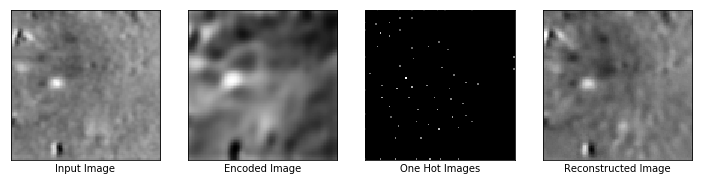

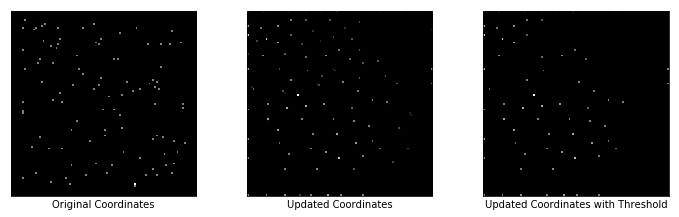

Epochs: 300, Session: 3
Reconstruction Loss: 0.0007593064801767468
Regularizer Loss: 111679.671875, Total Loss: 111679.671875
Encoder Loss: 5.219733715057373
Max Similarity scores: 0.8894867897033691
Updated Coordinates: [[[0.42428118 0.7665032 ]]]
Gradient global min:-0.00044927658746019006, max:0.0005293741123750806
Gradient encoder min:-1.2254319190979004, max:1.6420769691467285
Gradient learnable coords min:-1.4660076885775197e-05, max:1.0202315024798736e-05



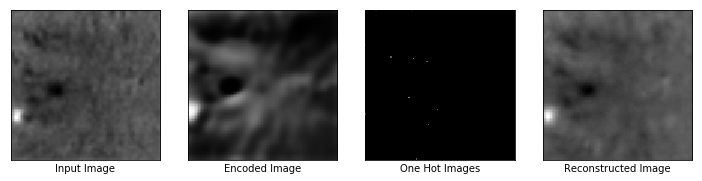

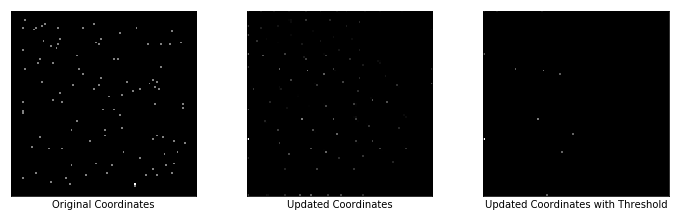

Epochs: 300, Session: 4
Reconstruction Loss: 0.0009405693272128701
Regularizer Loss: 110177.9609375, Total Loss: 110177.9609375
Encoder Loss: 3.357750654220581
Max Similarity scores: 0.8776305317878723
Updated Coordinates: [[[0.4224448 0.7685715]]]
Gradient global min:-0.0006518258596770465, max:0.001096678664907813
Gradient encoder min:-0.8117682933807373, max:1.047979712486267
Gradient learnable coords min:-1.639169749978464e-05, max:1.793206320144236e-05



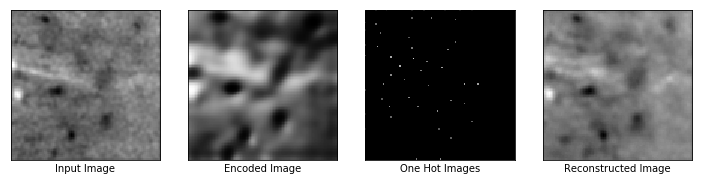

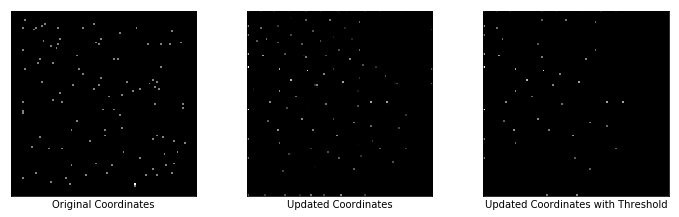

Epochs: 300, Session: 5
Reconstruction Loss: 0.0017592819640412927
Regularizer Loss: 117757.5546875, Total Loss: 117757.5546875
Encoder Loss: 6.34368896484375
Max Similarity scores: 0.8858386874198914
Updated Coordinates: [[[0.4310272 0.766166 ]]]
Gradient global min:-0.0006888679345138371, max:0.0005853198235854506
Gradient encoder min:-1.670496940612793, max:2.1362788677215576
Gradient learnable coords min:-1.7229269360541366e-05, max:6.464123998739524e-06



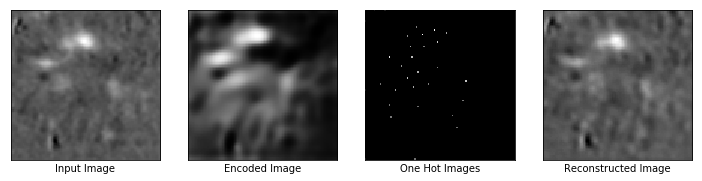

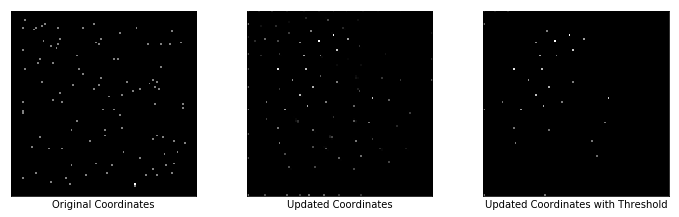

Epochs: 400, Session: 0
Reconstruction Loss: 0.0009515313431620598
Regularizer Loss: 119507.1171875, Total Loss: 119507.1171875
Encoder Loss: 3.739036798477173
Max Similarity scores: 0.7251059412956238
Updated Coordinates: [[[0.4227529 0.7428306]]]
Gradient global min:-0.0007655234076082706, max:0.0009218502091243863
Gradient encoder min:-1.2944881916046143, max:1.1260498762130737
Gradient learnable coords min:-9.700439477455802e-06, max:2.0622021111194044e-05



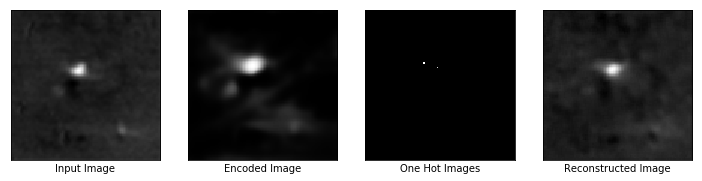

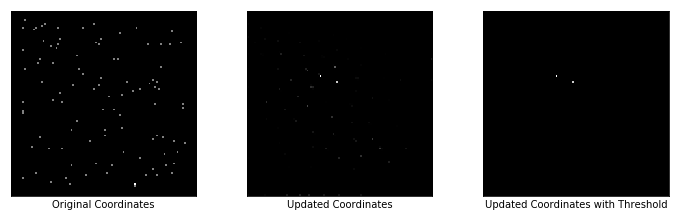

Epochs: 400, Session: 1
Reconstruction Loss: 0.0009551690891385078
Regularizer Loss: 123250.3046875, Total Loss: 123250.3046875
Encoder Loss: 0.8566911220550537
Max Similarity scores: 0.760095477104187
Updated Coordinates: [[[0.42688882 0.7464437 ]]]
Gradient global min:-0.00026832931325770915, max:0.0003517625737003982
Gradient encoder min:-0.4119288921356201, max:0.44506314396858215
Gradient learnable coords min:-0.00010309709614375606, max:1.6032574421842583e-05



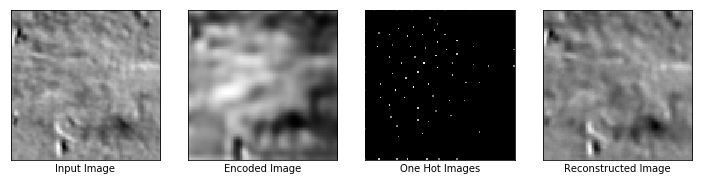

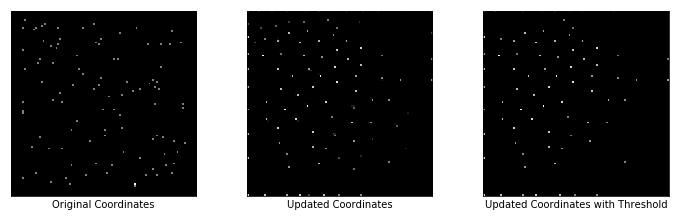

Epochs: 400, Session: 2
Reconstruction Loss: 0.0011414735345169902
Regularizer Loss: 123311.921875, Total Loss: 123311.921875
Encoder Loss: 6.514133453369141
Max Similarity scores: 0.7782931327819824
Updated Coordinates: [[[0.42629555 0.7504284 ]]]
Gradient global min:-0.00028714287327602506, max:0.0008001273381523788
Gradient encoder min:-2.352185010910034, max:1.7604856491088867
Gradient learnable coords min:-1.1481713045213837e-05, max:6.435177510866197e-06



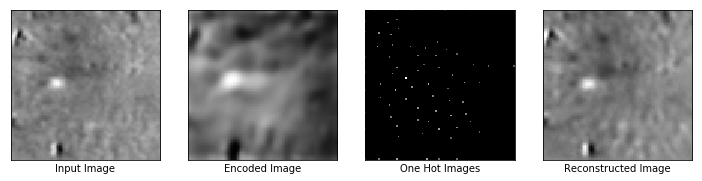

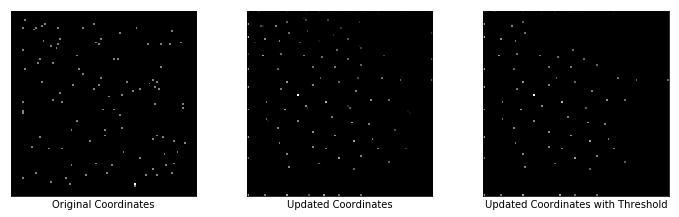

Epochs: 400, Session: 3
Reconstruction Loss: 0.0006854385137557983
Regularizer Loss: 116218.34375, Total Loss: 116218.34375
Encoder Loss: 4.906749248504639
Max Similarity scores: 0.8803445100784302
Updated Coordinates: [[[0.4256464  0.75030684]]]
Gradient global min:-0.0006007487536408007, max:0.0005745626986026764
Gradient encoder min:-1.7558560371398926, max:1.4408479928970337
Gradient learnable coords min:-8.887971489457414e-06, max:1.1930082109756768e-05



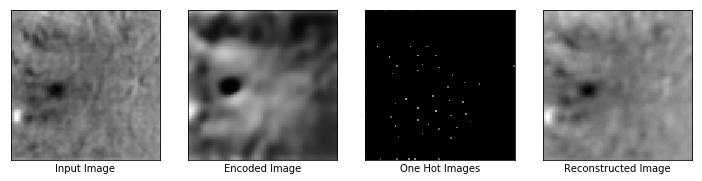

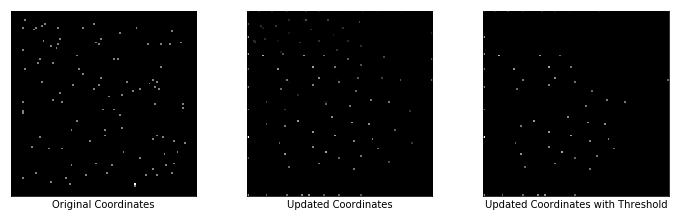

Epochs: 400, Session: 4
Reconstruction Loss: 0.000909854774363339
Regularizer Loss: 116991.109375, Total Loss: 116991.109375
Encoder Loss: 3.1672439575195312
Max Similarity scores: 0.8184083104133606
Updated Coordinates: [[[0.42437193 0.7676992 ]]]
Gradient global min:-0.0008683550986461341, max:0.0011809327406808734
Gradient encoder min:-1.1232815980911255, max:0.9995142221450806
Gradient learnable coords min:-5.780610081274062e-06, max:2.2078476831666194e-05



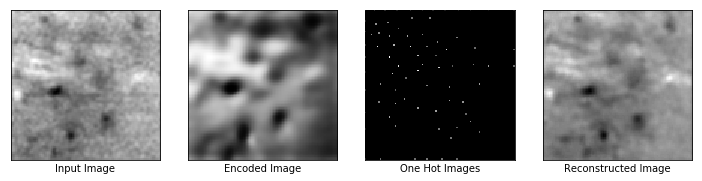

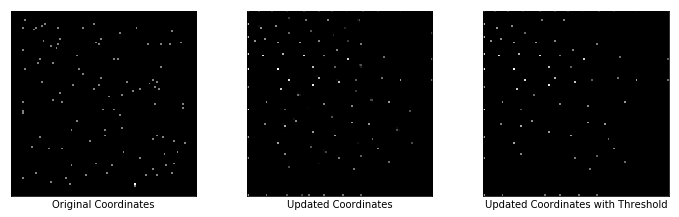

Epochs: 400, Session: 5
Reconstruction Loss: 0.0016653211787343025
Regularizer Loss: 121526.1015625, Total Loss: 121526.1015625
Encoder Loss: 5.882894515991211
Max Similarity scores: 0.8617889285087585
Updated Coordinates: [[[0.4203373  0.76629263]]]
Gradient global min:-0.0013047200627624989, max:0.0011251941323280334
Gradient encoder min:-2.250356435775757, max:1.7482826709747314
Gradient learnable coords min:-3.312708213343285e-05, max:3.126009687548503e-05



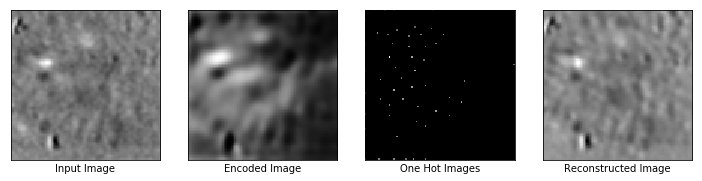

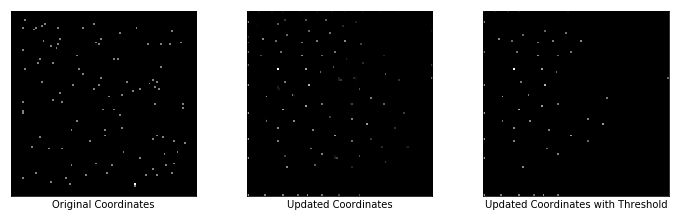

Epochs: 500, Session: 0
Reconstruction Loss: 0.0009111000108532608
Regularizer Loss: 139208.6875, Total Loss: 139208.6875
Encoder Loss: 3.232644557952881
Max Similarity scores: 0.7892179489135742
Updated Coordinates: [[[0.40170446 0.77550775]]]
Gradient global min:-0.00047172891208902, max:0.0004840128240175545
Gradient encoder min:-1.3309379816055298, max:1.275922179222107
Gradient learnable coords min:-3.788881440414116e-05, max:2.2154670659801923e-05



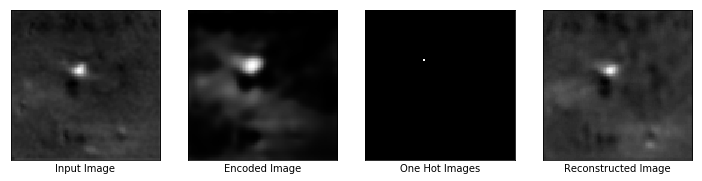

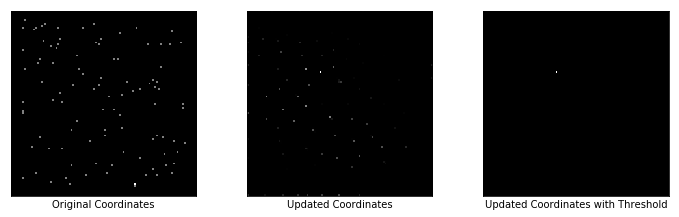

Epochs: 500, Session: 1
Reconstruction Loss: 0.0010417408775538206
Regularizer Loss: 148037.59375, Total Loss: 148037.59375
Encoder Loss: 0.7938318848609924
Max Similarity scores: 0.5057847499847412
Updated Coordinates: [[[0.4020178 0.7750075]]]
Gradient global min:-0.0017749201506376266, max:0.0026066508144140244
Gradient encoder min:-0.43333885073661804, max:0.4851388931274414
Gradient learnable coords min:-1.59614828589838e-05, max:0.0002831624587997794



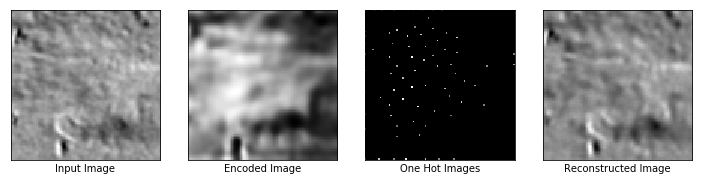

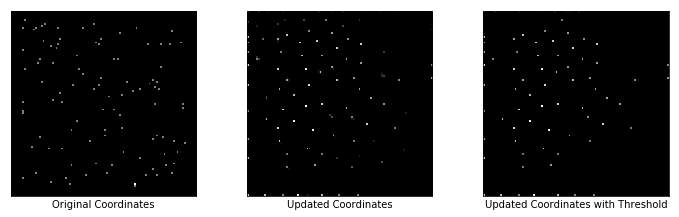

Epochs: 500, Session: 2
Reconstruction Loss: 0.0010361821623519063
Regularizer Loss: 139554.6875, Total Loss: 139554.6875
Encoder Loss: 5.7043867111206055
Max Similarity scores: 0.6792399883270264
Updated Coordinates: [[[0.4024753  0.77534074]]]
Gradient global min:-0.0009761695400811732, max:0.0011546715395525098
Gradient encoder min:-2.500211715698242, max:2.008425235748291
Gradient learnable coords min:-1.5478828572668135e-05, max:8.85197277966654e-06



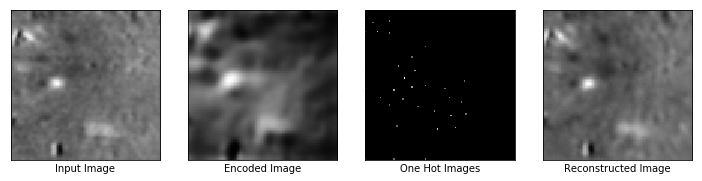

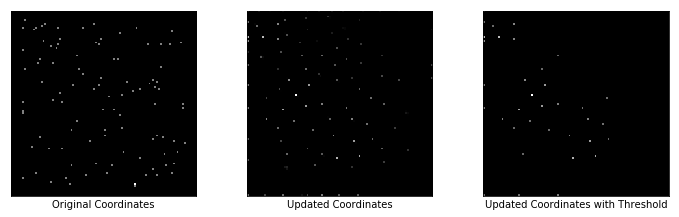

Epochs: 500, Session: 3
Reconstruction Loss: 0.000679641671013087
Regularizer Loss: 133130.59375, Total Loss: 133130.59375
Encoder Loss: 4.154033660888672
Max Similarity scores: 0.794187068939209
Updated Coordinates: [[[0.4042841 0.7748007]]]
Gradient global min:-0.0034144618548452854, max:0.00362016330473125
Gradient encoder min:-1.8138107061386108, max:1.5963271856307983
Gradient learnable coords min:-4.186417754681315e-06, max:5.655284439853858e-06



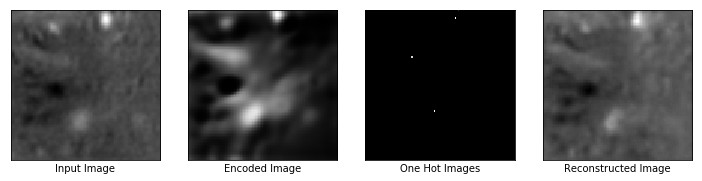

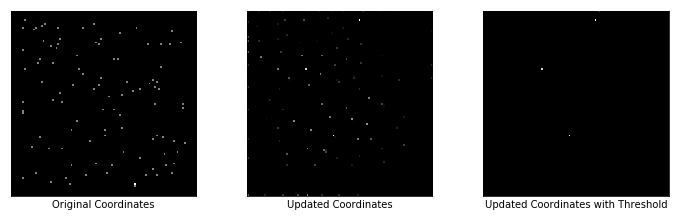

Epochs: 500, Session: 4
Reconstruction Loss: 0.000780017115175724
Regularizer Loss: 136729.890625, Total Loss: 136729.890625
Encoder Loss: 2.6488723754882812
Max Similarity scores: 0.5575910806655884
Updated Coordinates: [[[0.41922462 0.7590324 ]]]
Gradient global min:-0.0009700320078991354, max:0.0010622161207720637
Gradient encoder min:-1.0933420658111572, max:1.0553239583969116
Gradient learnable coords min:-7.380807346635265e-06, max:2.022322587436065e-05



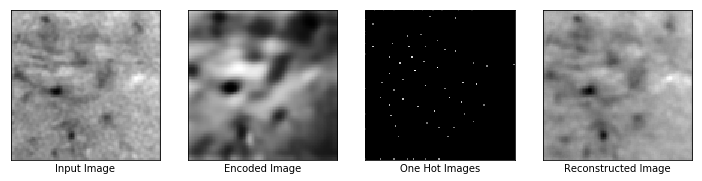

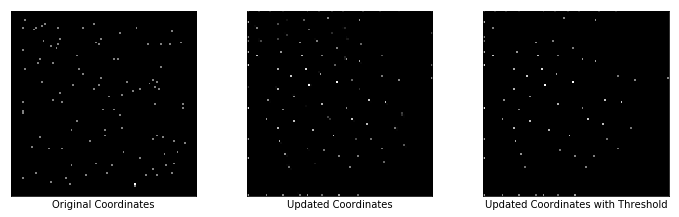

Epochs: 500, Session: 5
Reconstruction Loss: 0.001578657771460712
Regularizer Loss: 137763.71875, Total Loss: 137763.71875
Encoder Loss: 4.992993354797363
Max Similarity scores: 0.8087305426597595
Updated Coordinates: [[[0.41153806 0.75430727]]]
Gradient global min:-0.006683930289000273, max:0.004062599968165159
Gradient encoder min:-2.317885160446167, max:1.9654659032821655
Gradient learnable coords min:-7.083854598022299e-06, max:1.4327946701087058e-05



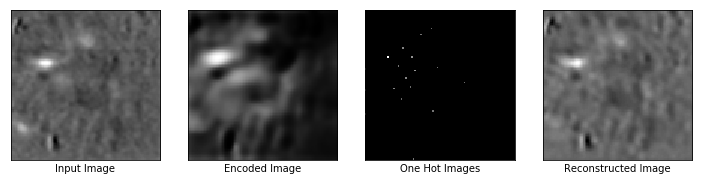

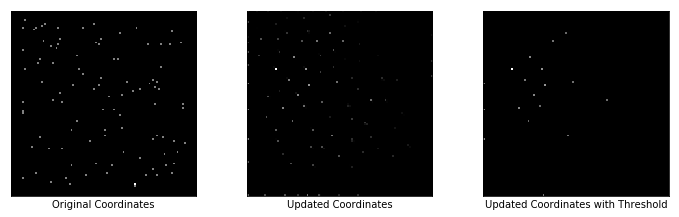

Epochs: 600, Session: 0
Reconstruction Loss: 0.0007966426783241332
Regularizer Loss: 187462.0, Total Loss: 187462.0
Encoder Loss: 2.981764793395996
Max Similarity scores: 0.7865604162216187
Updated Coordinates: [[[0.40811214 0.7417237 ]]]
Gradient global min:-0.0003697763604577631, max:0.0003851104702334851
Gradient encoder min:-0.9937126636505127, max:0.807409942150116
Gradient learnable coords min:-2.277458770549856e-05, max:9.44904240895994e-05



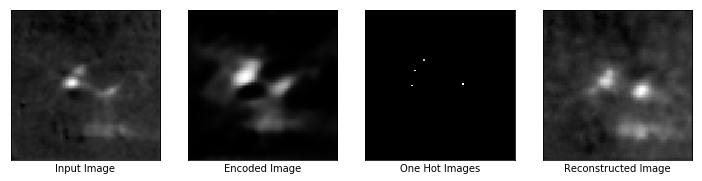

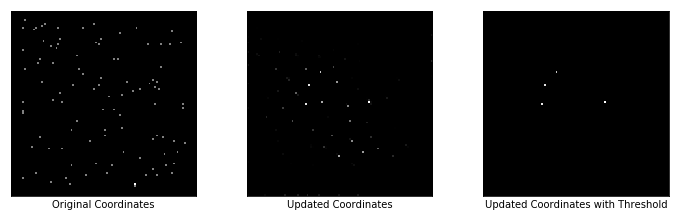

Epochs: 600, Session: 1
Reconstruction Loss: 0.0007819909369572997
Regularizer Loss: 205745.390625, Total Loss: 205745.390625
Encoder Loss: 0.6756064891815186
Max Similarity scores: 0.531569242477417
Updated Coordinates: [[[0.41778    0.73777974]]]
Gradient global min:-0.001271787565201521, max:0.002609762828797102
Gradient encoder min:-0.32391926646232605, max:0.3310231566429138
Gradient learnable coords min:-1.9900691768270917e-05, max:2.56608946074266e-05



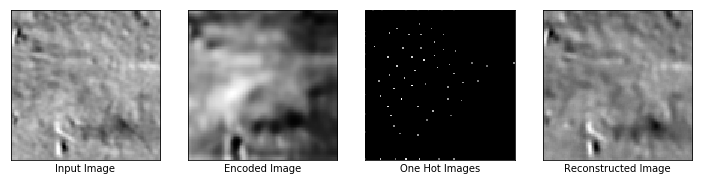

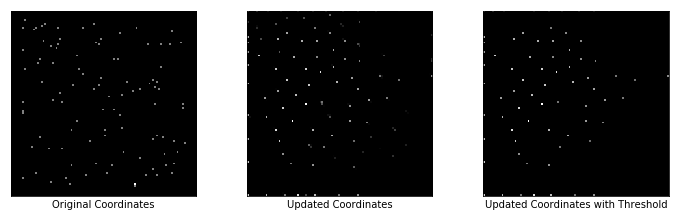

Epochs: 600, Session: 2
Reconstruction Loss: 0.0009966951329261065
Regularizer Loss: 183866.640625, Total Loss: 183866.640625
Encoder Loss: 5.291934013366699
Max Similarity scores: 0.7313848733901978
Updated Coordinates: [[[0.41631767 0.7404908 ]]]
Gradient global min:-0.000982446945272386, max:0.0008143443847075105
Gradient encoder min:-1.9088014364242554, max:1.3344693183898926
Gradient learnable coords min:-1.5078273463586811e-05, max:8.311253623105586e-06



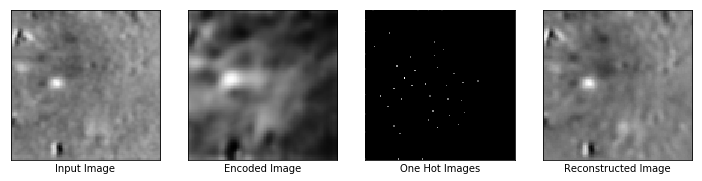

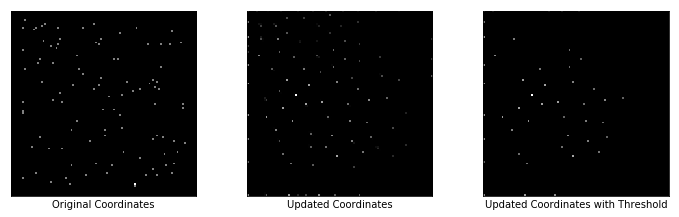

Epochs: 600, Session: 3
Reconstruction Loss: 0.000648080836981535
Regularizer Loss: 177454.6875, Total Loss: 177454.6875
Encoder Loss: 3.8272886276245117
Max Similarity scores: 0.8226841688156128
Updated Coordinates: [[[0.42623082 0.7388642 ]]]
Gradient global min:-0.002023746958002448, max:0.0023495364002883434
Gradient encoder min:-1.2884624004364014, max:1.009742259979248
Gradient learnable coords min:-3.089158781222068e-05, max:1.1896557225554716e-05



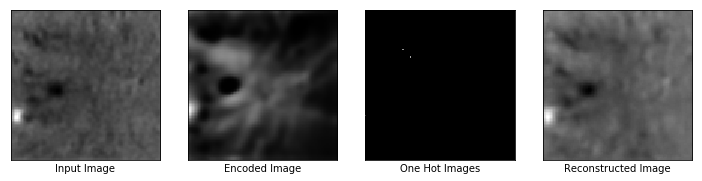

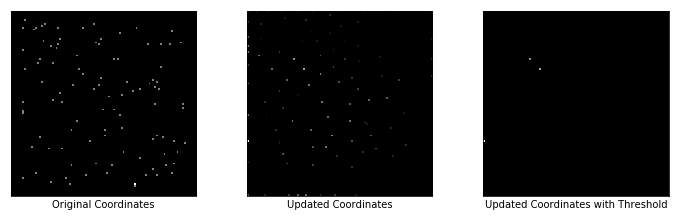

Epochs: 600, Session: 4
Reconstruction Loss: 0.0007593201589770615
Regularizer Loss: 184395.125, Total Loss: 184395.125
Encoder Loss: 2.4404456615448
Max Similarity scores: 0.5855382680892944
Updated Coordinates: [[[0.4270359 0.7365651]]]
Gradient global min:-0.005490412004292011, max:0.013023106381297112
Gradient encoder min:-0.9785115122795105, max:0.6881343722343445
Gradient learnable coords min:-5.266982952889521e-06, max:1.1210282536922023e-05



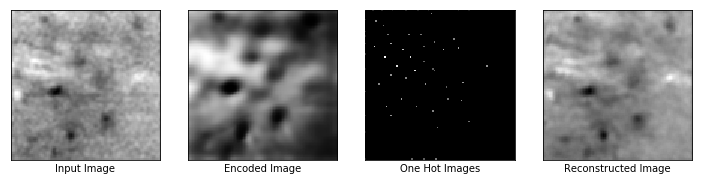

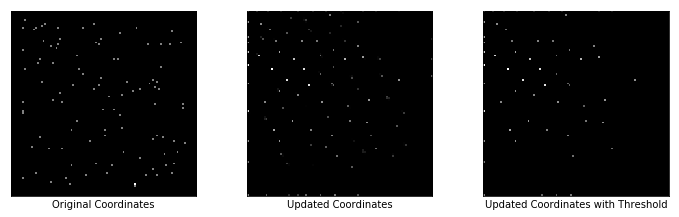

Epochs: 600, Session: 5
Reconstruction Loss: 0.0015044818865135312
Regularizer Loss: 181866.875, Total Loss: 181866.875
Encoder Loss: 4.74321985244751
Max Similarity scores: 0.8336688280105591
Updated Coordinates: [[[0.42299667 0.73609495]]]
Gradient global min:-0.00013150586164556444, max:0.0003698495274875313
Gradient encoder min:-1.7621163129806519, max:1.2866629362106323
Gradient learnable coords min:-5.3673329603043385e-06, max:1.3358189789869357e-05



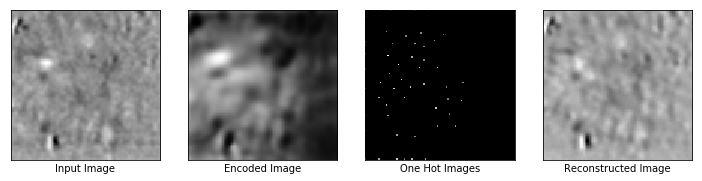

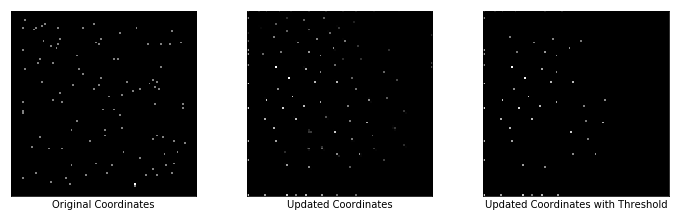

Epochs: 700, Session: 0
Reconstruction Loss: 0.0007721651345491409
Regularizer Loss: 211149.15625, Total Loss: 211149.15625
Encoder Loss: 2.5498404502868652
Max Similarity scores: 0.6693936586380005
Updated Coordinates: [[[0.40421438 0.7424934 ]]]
Gradient global min:-0.0021122489124536514, max:0.006196681875735521
Gradient encoder min:-0.804542601108551, max:0.8746175169944763
Gradient learnable coords min:-1.6112859157146886e-05, max:7.723766429990064e-06



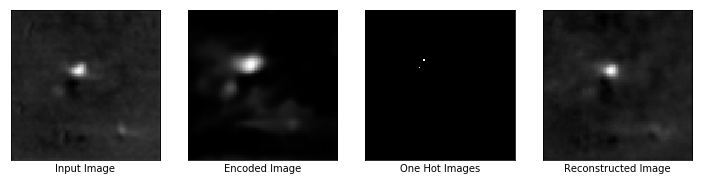

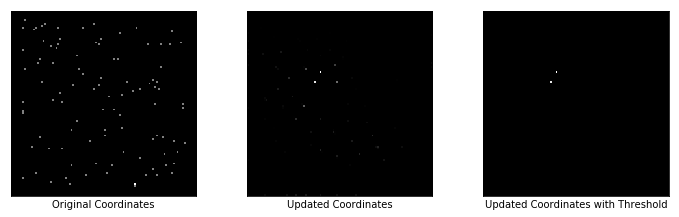

Epochs: 700, Session: 1
Reconstruction Loss: 0.000863186432980001
Regularizer Loss: 238815.515625, Total Loss: 238815.515625
Encoder Loss: 0.5578521490097046
Max Similarity scores: 0.5413805246353149
Updated Coordinates: [[[0.39560348 0.75534374]]]
Gradient global min:-0.00047753521357662976, max:0.0003958082234021276
Gradient encoder min:-0.2774274945259094, max:0.2607891261577606
Gradient learnable coords min:-2.3375434466288425e-05, max:1.5435120076290332e-05



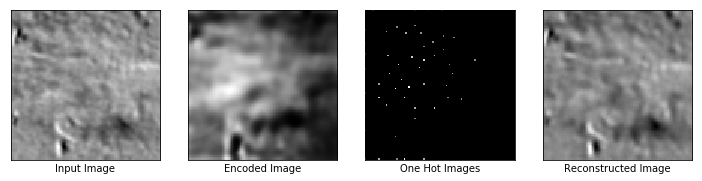

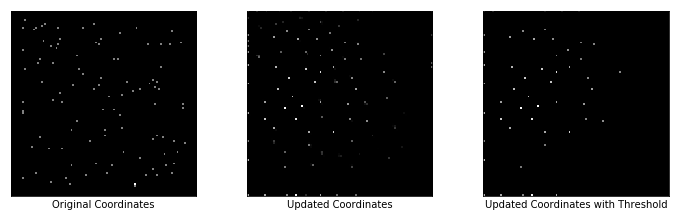

Epochs: 700, Session: 2
Reconstruction Loss: 0.0009533458505757153
Regularizer Loss: 203339.53125, Total Loss: 203339.53125
Encoder Loss: 4.511816501617432
Max Similarity scores: 0.6683531999588013
Updated Coordinates: [[[0.40259936 0.7710934 ]]]
Gradient global min:-0.00015099681331776083, max:0.0007924945093691349
Gradient encoder min:-1.4777977466583252, max:1.48098623752594
Gradient learnable coords min:-1.646312557568308e-05, max:1.2608577890205197e-05



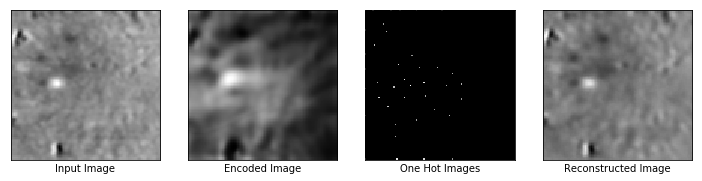

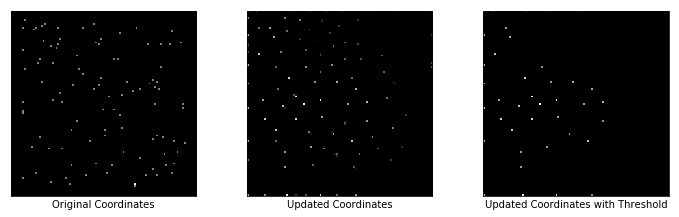

Epochs: 700, Session: 3
Reconstruction Loss: 0.0006599414627999067
Regularizer Loss: 198315.734375, Total Loss: 198315.734375
Encoder Loss: 3.2228481769561768
Max Similarity scores: 0.751757800579071
Updated Coordinates: [[[0.41733262 0.7453235 ]]]
Gradient global min:-0.00042015622602775693, max:0.0011591921793296933
Gradient encoder min:-1.0354633331298828, max:1.064031720161438
Gradient learnable coords min:-8.293456630781293e-06, max:2.0137056708335876e-05



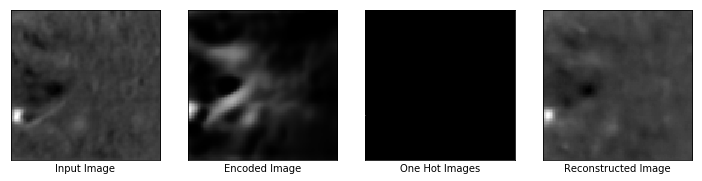

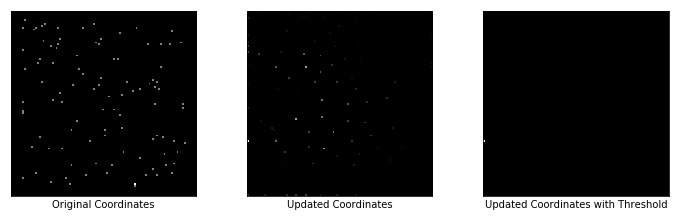

Epochs: 700, Session: 4
Reconstruction Loss: 0.000739723036531359
Regularizer Loss: 209028.125, Total Loss: 209028.125
Encoder Loss: 1.9633615016937256
Max Similarity scores: 0.47560831904411316
Updated Coordinates: [[[0.4147446 0.7484252]]]
Gradient global min:-0.0011144560994580388, max:0.001220131409354508
Gradient encoder min:-0.7121827006340027, max:0.6615230441093445
Gradient learnable coords min:-1.6678481188137084e-05, max:6.242485142138321e-06



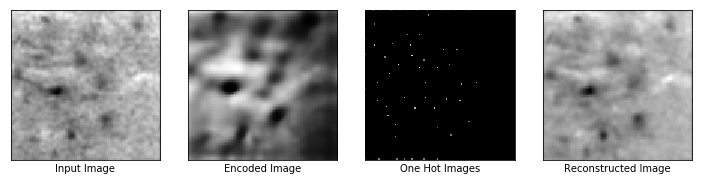

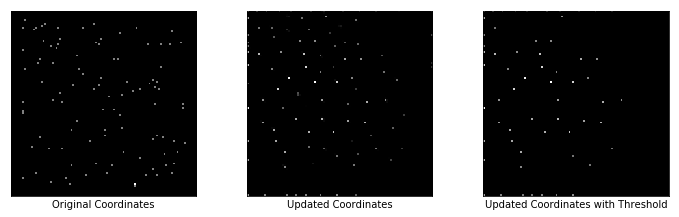

Epochs: 700, Session: 5
Reconstruction Loss: 0.0015413130167871714
Regularizer Loss: 202315.453125, Total Loss: 202315.453125
Encoder Loss: 3.966027021408081
Max Similarity scores: 0.6855735182762146
Updated Coordinates: [[[0.41761303 0.74706995]]]
Gradient global min:-0.0005592687521129847, max:0.00028482440393418074
Gradient encoder min:-1.3228811025619507, max:1.4741665124893188
Gradient learnable coords min:-1.593753586348612e-05, max:9.874902389128692e-06



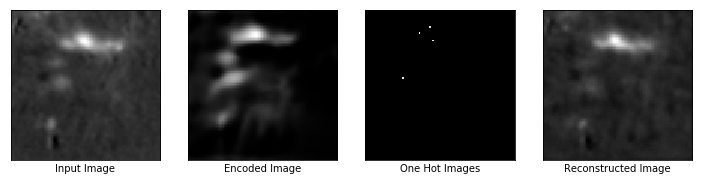

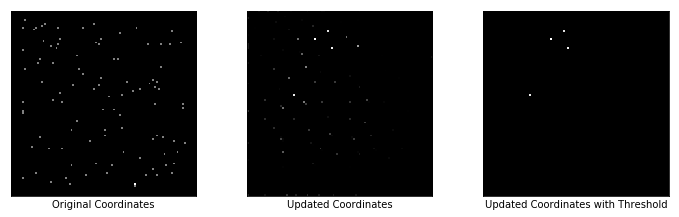

Epochs: 800, Session: 0
Reconstruction Loss: 0.0007540343794971704
Regularizer Loss: 242845.484375, Total Loss: 242845.484375
Encoder Loss: 2.133343458175659
Max Similarity scores: 0.3868243098258972
Updated Coordinates: [[[0.39307442 0.74363714]]]
Gradient global min:-0.0011250715469941497, max:0.001415539183653891
Gradient encoder min:-0.7381591200828552, max:0.7612254023551941
Gradient learnable coords min:-2.5026540242834017e-05, max:7.082745923980838e-06



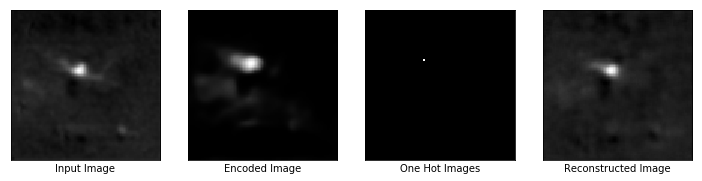

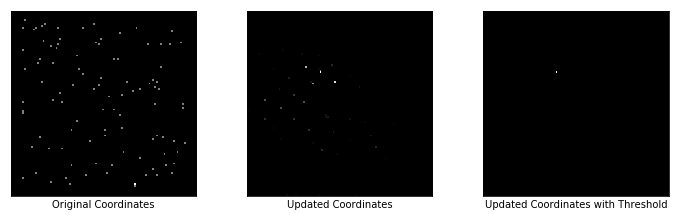

Epochs: 800, Session: 1
Reconstruction Loss: 0.0008458803058601916
Regularizer Loss: 284432.0625, Total Loss: 284432.0625
Encoder Loss: 0.461405873298645
Max Similarity scores: 0.5078768134117126
Updated Coordinates: [[[0.3986506 0.7506099]]]
Gradient global min:-0.001328064827248454, max:0.0008455122006125748
Gradient encoder min:-0.22191792726516724, max:0.2031404972076416
Gradient learnable coords min:-0.00011199286382179707, max:0.00012463971506804228



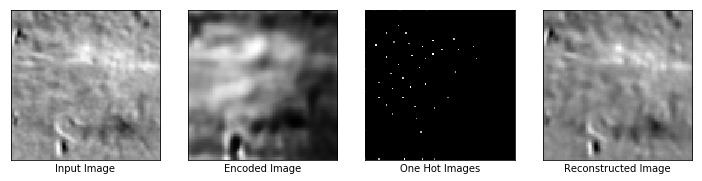

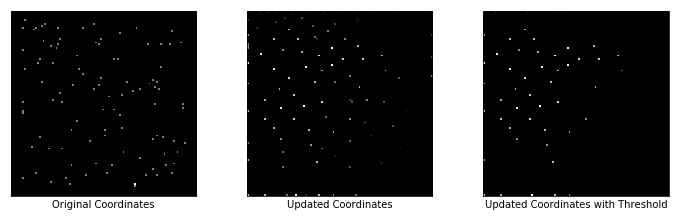

Epochs: 800, Session: 2
Reconstruction Loss: 0.0008580551366321743
Regularizer Loss: 227520.53125, Total Loss: 227520.53125
Encoder Loss: 3.938229560852051
Max Similarity scores: 0.5803138017654419
Updated Coordinates: [[[0.40551102 0.7457402 ]]]
Gradient global min:-0.0008637905702926219, max:0.0006696194759570062
Gradient encoder min:-1.2204885482788086, max:1.3751206398010254
Gradient learnable coords min:-5.385158601711737e-06, max:5.376007720769849e-06



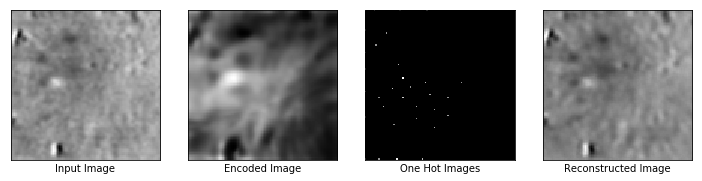

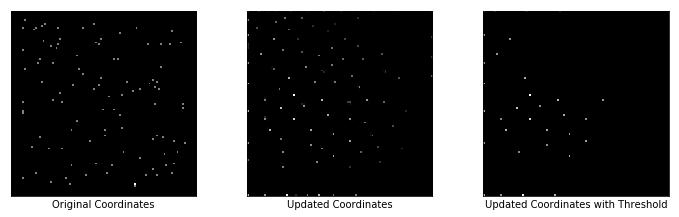

Epochs: 800, Session: 3
Reconstruction Loss: 0.0005744094378314912
Regularizer Loss: 224943.484375, Total Loss: 224943.484375
Encoder Loss: 2.790360689163208
Max Similarity scores: 0.572091817855835
Updated Coordinates: [[[0.40603188 0.7457221 ]]]
Gradient global min:-0.0006509186932817101, max:0.0007492362638004124
Gradient encoder min:-0.8585866689682007, max:0.972989559173584
Gradient learnable coords min:-4.593401627062121e-06, max:5.344899182091467e-05



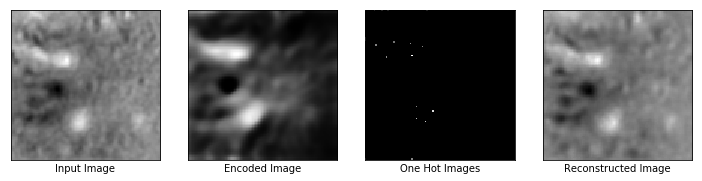

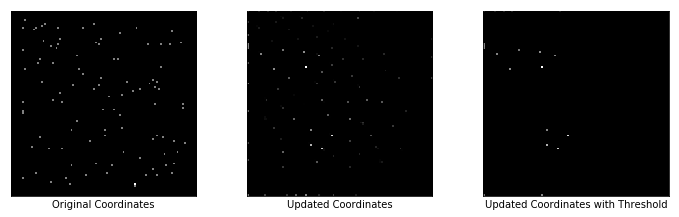

Epochs: 800, Session: 4
Reconstruction Loss: 0.0010285882744938135
Regularizer Loss: 241727.46875, Total Loss: 241727.46875
Encoder Loss: 1.5972392559051514
Max Similarity scores: 0.7328070402145386
Updated Coordinates: [[[0.40748167 0.7462261 ]]]
Gradient global min:-0.0037301399279385805, max:0.004191369749605656
Gradient encoder min:-0.6139225959777832, max:0.5776265263557434
Gradient learnable coords min:-4.55716326541733e-05, max:3.050888335565105e-05



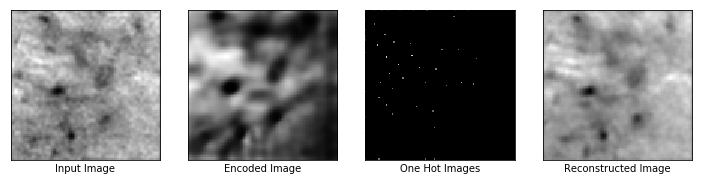

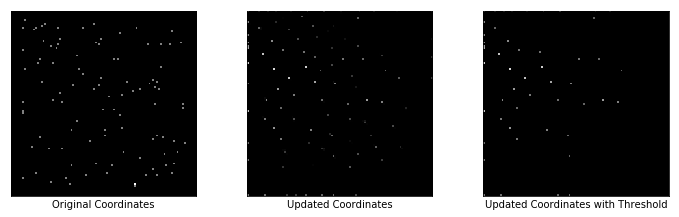

Epochs: 800, Session: 5
Reconstruction Loss: 0.001477747573517263
Regularizer Loss: 225952.0625, Total Loss: 225952.0625
Encoder Loss: 3.5461294651031494
Max Similarity scores: 0.6795534491539001
Updated Coordinates: [[[0.40899807 0.7474955 ]]]
Gradient global min:-0.0009601530036889017, max:0.0007868033135309815
Gradient encoder min:-1.156237006187439, max:1.4425575733184814
Gradient learnable coords min:-1.3419347851595376e-05, max:1.0800470590766054e-05



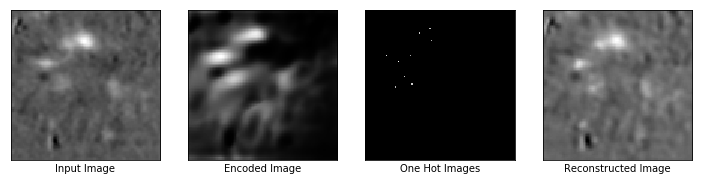

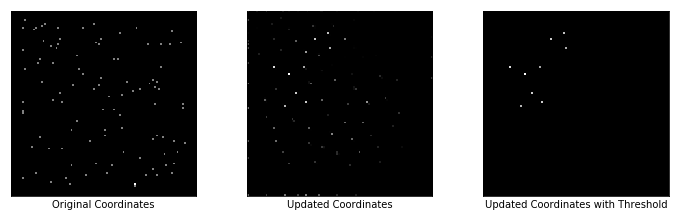

Epochs: 900, Session: 0
Reconstruction Loss: 0.0008052799967117608
Regularizer Loss: 293135.5, Total Loss: 293135.5
Encoder Loss: 1.9354116916656494
Max Similarity scores: 0.46878165006637573
Updated Coordinates: [[[0.4087907 0.7371435]]]
Gradient global min:-0.0006265031988732517, max:0.0004974721814505756
Gradient encoder min:-0.6335912942886353, max:0.6132418513298035
Gradient learnable coords min:-1.0516750080569182e-05, max:2.1920395738561638e-05



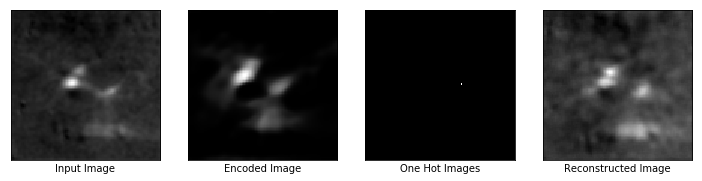

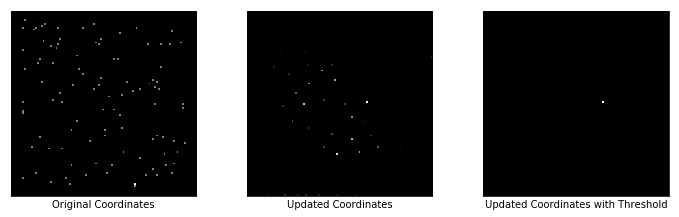

Epochs: 900, Session: 1
Reconstruction Loss: 0.0008206369238905609
Regularizer Loss: 329792.375, Total Loss: 329792.375
Encoder Loss: 0.4036475121974945
Max Similarity scores: 0.3084511160850525
Updated Coordinates: [[[0.41125917 0.73546124]]]
Gradient global min:-0.0030248016119003296, max:0.007143947295844555
Gradient encoder min:-0.21306763589382172, max:0.18455283343791962
Gradient learnable coords min:-1.1280299986538012e-05, max:1.4384000678546727e-05



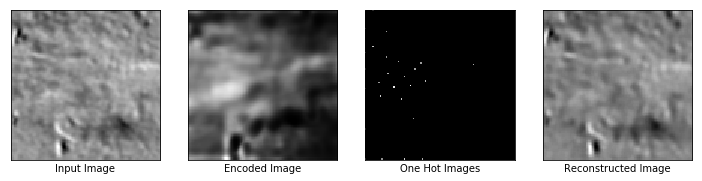

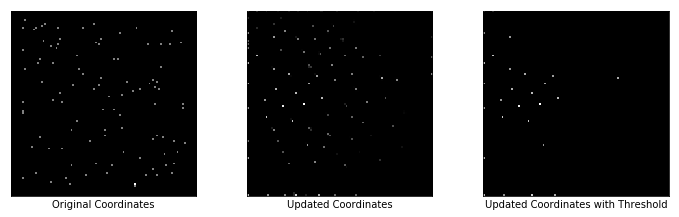

Epochs: 900, Session: 2
Reconstruction Loss: 0.0008437930955551565
Regularizer Loss: 282246.125, Total Loss: 282246.125
Encoder Loss: 3.5341124534606934
Max Similarity scores: 0.6374735832214355
Updated Coordinates: [[[0.41300094 0.735852  ]]]
Gradient global min:-9.915042028296739e-05, max:8.614650869276375e-05
Gradient encoder min:-1.1390563249588013, max:1.2714948654174805
Gradient learnable coords min:-3.567206658772193e-05, max:2.418921940261498e-05



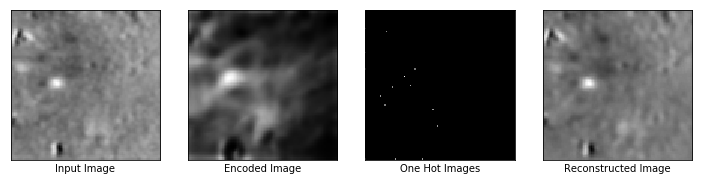

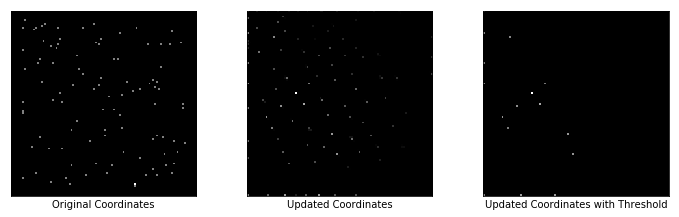

Epochs: 900, Session: 3
Reconstruction Loss: 0.0006356860976666212
Regularizer Loss: 276568.1875, Total Loss: 276568.1875
Encoder Loss: 2.4340786933898926
Max Similarity scores: 0.6550063490867615
Updated Coordinates: [[[0.41339388 0.73541623]]]
Gradient global min:-0.0019171839812770486, max:0.002086455002427101
Gradient encoder min:-0.7217797040939331, max:0.7377105951309204
Gradient learnable coords min:-7.129732694011182e-05, max:2.7087076887255535e-05



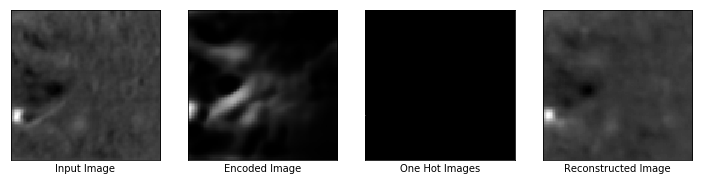

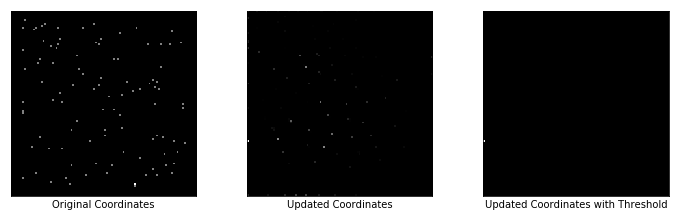

Epochs: 900, Session: 4
Reconstruction Loss: 0.0008741270285099745
Regularizer Loss: 291781.65625, Total Loss: 291781.65625
Encoder Loss: 1.437576413154602
Max Similarity scores: 0.42851749062538147
Updated Coordinates: [[[0.41406128 0.7358086 ]]]
Gradient global min:-0.0028749422635883093, max:0.0033658877946436405
Gradient encoder min:-0.502053439617157, max:0.44576606154441833
Gradient learnable coords min:-3.510148235363886e-05, max:1.7535205188323744e-05



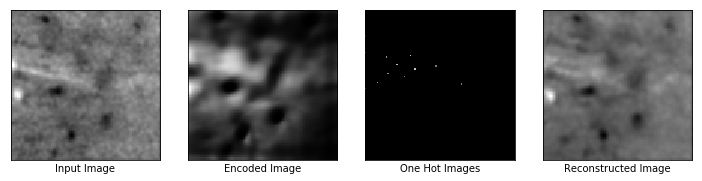

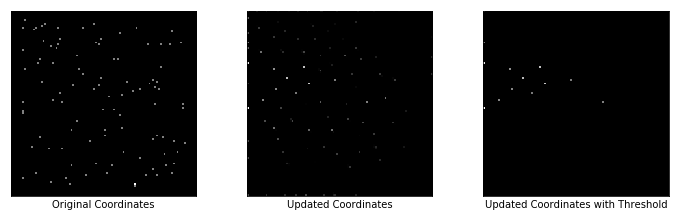

Epochs: 900, Session: 5
Reconstruction Loss: 0.0014990762574598193
Regularizer Loss: 281844.375, Total Loss: 281844.375
Encoder Loss: 3.1320159435272217
Max Similarity scores: 0.6548986434936523
Updated Coordinates: [[[0.41360867 0.7391384 ]]]
Gradient global min:-0.001712797791697085, max:0.0009852114599198103
Gradient encoder min:-1.028201699256897, max:1.10276198387146
Gradient learnable coords min:-1.5616118616890162e-05, max:1.2987588888790924e-05



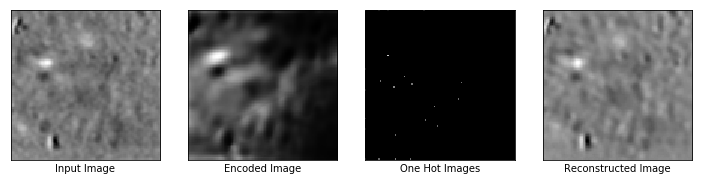

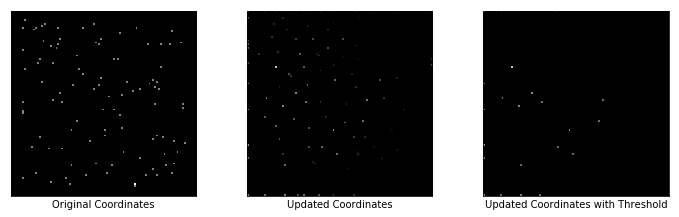

Epochs: 1000, Session: 0
Reconstruction Loss: 0.0008495597867295146
Regularizer Loss: 380563.25, Total Loss: 380563.25
Encoder Loss: 1.9177402257919312
Max Similarity scores: 0.6182483434677124
Updated Coordinates: [[[0.40473157 0.73678774]]]
Gradient global min:-0.0014207838103175163, max:0.0016535804606974125
Gradient encoder min:-0.8036067485809326, max:0.8400251865386963
Gradient learnable coords min:-0.0002269313408760354, max:7.993161852937192e-05



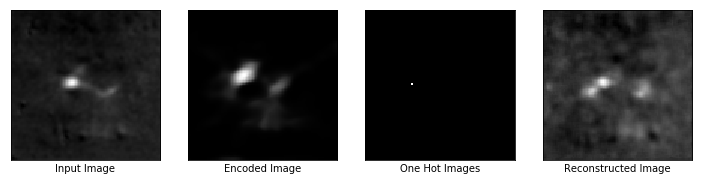

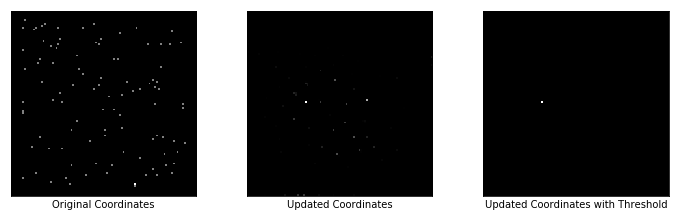

Epochs: 1000, Session: 1
Reconstruction Loss: 0.0007448116666637361
Regularizer Loss: 404643.40625, Total Loss: 404643.40625
Encoder Loss: 0.40950480103492737
Max Similarity scores: 0.3225860595703125
Updated Coordinates: [[[0.40409645 0.73354375]]]
Gradient global min:-0.00033800266101025045, max:0.00045959901763126254
Gradient encoder min:-0.2014053761959076, max:0.19951653480529785
Gradient learnable coords min:-0.00013680603296961635, max:9.629556188883726e-06



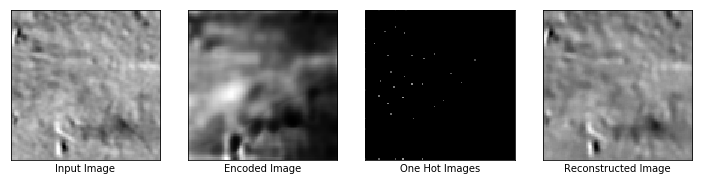

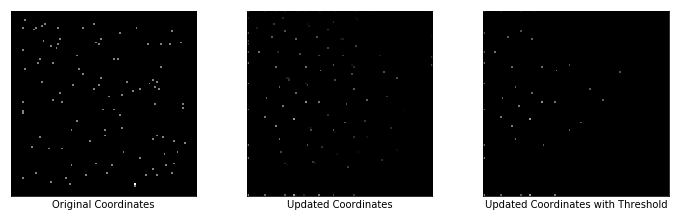

Epochs: 1000, Session: 2
Reconstruction Loss: 0.000888488779310137
Regularizer Loss: 379728.375, Total Loss: 379728.375
Encoder Loss: 3.454906702041626
Max Similarity scores: 0.6548363566398621
Updated Coordinates: [[[0.40578932 0.73643595]]]
Gradient global min:-0.001210374990478158, max:0.001284979865886271
Gradient encoder min:-1.5873051881790161, max:1.7659204006195068
Gradient learnable coords min:-2.061272425635252e-05, max:3.4811087971320376e-05



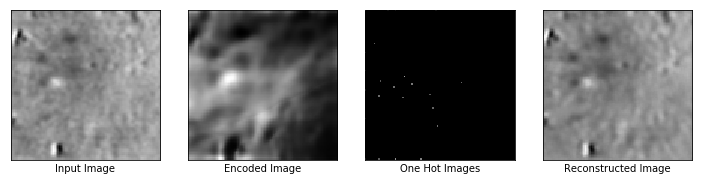

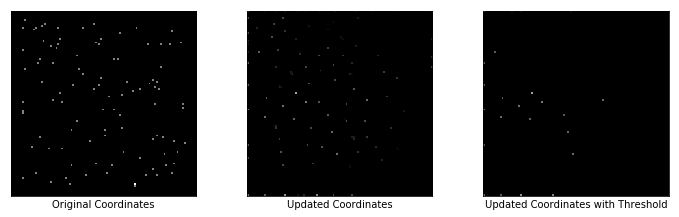

Epochs: 1000, Session: 3
Reconstruction Loss: 0.0005525128799490631
Regularizer Loss: 366182.90625, Total Loss: 366182.90625
Encoder Loss: 2.4414703845977783
Max Similarity scores: 0.5794462561607361
Updated Coordinates: [[[0.40730217 0.7359308 ]]]
Gradient global min:-0.0014303864445537329, max:0.0015326566062867641
Gradient encoder min:-1.059919834136963, max:1.0773143768310547
Gradient learnable coords min:-1.1707445992215071e-05, max:2.094713636324741e-05



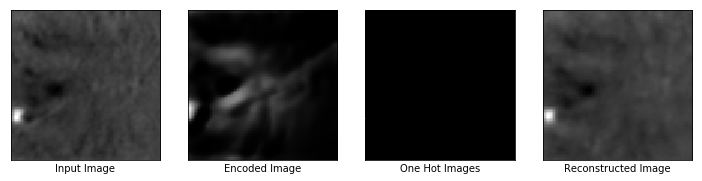

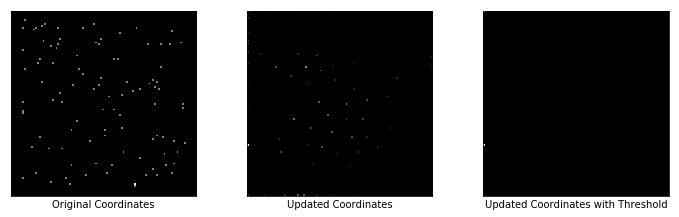

Epochs: 1000, Session: 4
Reconstruction Loss: 0.0007156695355661213
Regularizer Loss: 376219.71875, Total Loss: 376219.71875
Encoder Loss: 1.462342381477356
Max Similarity scores: 0.3589842915534973
Updated Coordinates: [[[0.40496194 0.7348762 ]]]
Gradient global min:-0.0002879219246096909, max:0.0001848610700108111
Gradient encoder min:-0.6484237909317017, max:0.6367679834365845
Gradient learnable coords min:-9.207804396282881e-06, max:2.6413375962874852e-05



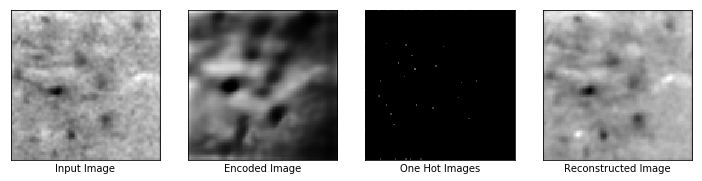

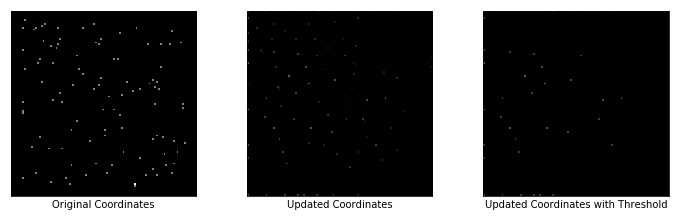

Epochs: 1000, Session: 5
Reconstruction Loss: 0.001466652611270547
Regularizer Loss: 378728.96875, Total Loss: 378728.96875
Encoder Loss: 3.0539910793304443
Max Similarity scores: 0.730893075466156
Updated Coordinates: [[[0.4120535 0.7300906]]]
Gradient global min:-0.00042494217632338405, max:0.000558663799893111
Gradient encoder min:-1.4350322484970093, max:1.5380955934524536
Gradient learnable coords min:-3.211029616068117e-05, max:2.6411949875182472e-05


In [12]:
# batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates', 'Updated Coordinates with Threshold']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
#one epochs => loop through all sessions
while epochs <= MAX_EPOCHS:
    sess = 0
    #loops through all the sessions
    for session in sorted(os.listdir(ds_dir)):
        merge_sess = os.path.join(ds_dir+session)
        merge_sess = np.load(merge_sess)
        #resize the images
        re_list = utils.resize(merge_sess, NEW_SIZE)
        #add channel 
        re_list = np.expand_dims(re_list, axis = -1)
        re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
        batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
        #initialize list to store data for sessions in last epochs
        one_hot_imgs_last_sess = []
        encoder_output_last_sess = []
        similarity_score_last_sess = []
        reconstruction_last_sess = []
        #loss for each session
        loss_sess = [] #reconstruction loss
        reg_loss_sess = [] #regularizer loss
        enc_loss_sess = [] #ecnoder loss
        for batched_imgs in batch_imgs:
            loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                                  IMG_SIZE, BATCH_SIZE,
                                                                                                                  neuron_multi = True,
                                                                                                                 one_hot_thr = True)
            #append all frames for final epochs per session!
            if epochs==MAX_EPOCHS:
                one_hot_imgs_last_sess.append(one_hot_imgs)
#                 encoder_output_last_sess.append(encoder_output)
                similarity_score_last_sess.append(similarity_score)
#                 reconstruction_last_sess.append(reconstruction)
        
        #append all sessions for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs_last_sess)
#             encoder_output_last_list.append(encoder_output_last_sess)
            similarity_score_last_list.append(similarity_score_last_sess)
#             reconstruction_last_list.append(reconstruction_last_sess)


        if epochs%100==0:
            rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
            img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand], reconstruction[rand]]
            img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(one_hot_imgs, similarity_score)[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand]]
            plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
            plot_comparison(img_row02, captions_02, n_col=len(img_row02), figsize = (10, 10))
            #print for each session in the epochs 
            #note for loss indices
            #loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
            print("Epochs: {}, Session: {}".format(epochs, sess))
            print("Reconstruction Loss: {}".format(loss[0].numpy()))
            print("Regularizer Loss: {}, Total Loss: {}".format(loss[2].numpy(), loss[-1].numpy()))
            print("Encoder Loss: {}".format(loss[1].numpy()))
            print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
            print("Updated Coordinates: {}".format(updated_coords[0]))
            print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
            print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
            print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
            #append to list 
            encoded_imgs.append(encoder_output)
            input_imgs.append(batched_imgs)
            coords_list.append(updated_coords)
            reconstructed_imgs.append(reconstruction)
            one_hot_imgs_list.append(one_hot_imgs)
            similarity_list.append(similarity_score)
        
        sess+=1
        #append all losses for each session
        loss_sess.append(loss[0])
        reg_loss_sess.append(loss[1])
        enc_loss_sess.append(loss[-1])
    #loss is append for each epochs
    loss_list_global.append(np.mean(np.array(loss_sess)))
    loss_list_encoded_one_hot.append(np.mean(np.array(reg_loss_sess)))
    regulariser_loss_list.append(np.mean(np.array(enc_loss_sess)))
    #increment epochs
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
store_name = [d.split(".")[0] for d in sorted(os.listdir(ds_dir))]
#intended save path 
int_save_path = path_desktop+'npy/{}/sim_one_{}'.format(ver, ver)
#create new file to store sim score and one hot images for last frames
if not os.path.exists(int_save_path):
    os.makedirs(int_save_path)

#save sim scores for every session in last epochs 
similarity_score_last_list = utils.concat_batch(similarity_score_last_list) #(sess, frames, n_neurons)
for idx, stack in enumerate(similarity_score_last_list):
    np.save(int_save_path+'/sim_last_{}_{}.npy'.format(store_name[idx], ver), np.array(stack))

In [16]:
#save one hot imgs for last epochs 
for idx,stack in enumerate(one_hot_imgs_last_list):
    tensor = tf.convert_to_tensor(stack, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
    np.save(int_save_path+'/one_last_{}_{}.npy'.format(store_name[idx], ver), np.array(tensor))

In [38]:
# #save info for every frames in last epochs
# save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
# save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

# for names, items in zip(save_names_last, save_list_last):
#     aggregate_tensor = utils.concat_batch(items)
#     np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [47]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [ ]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [19]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [20]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

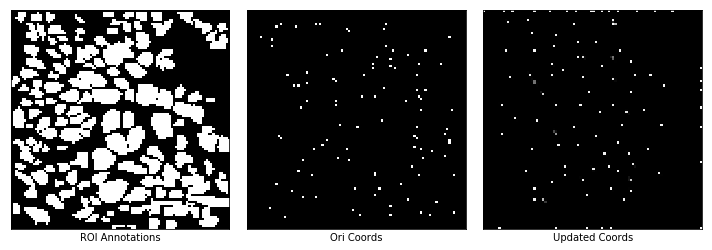

In [21]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.01
Counts:  108


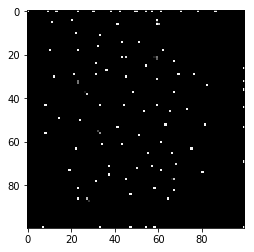

In [22]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

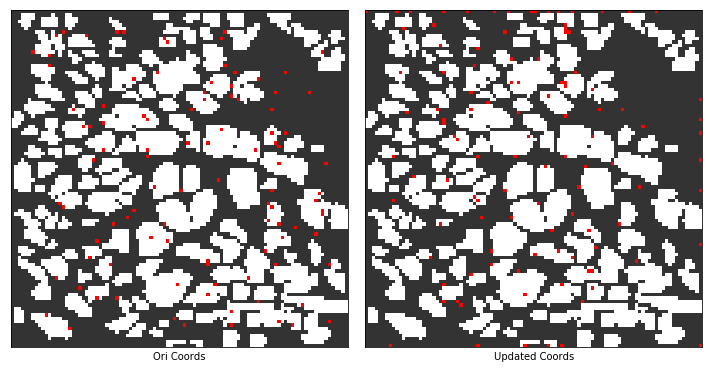

In [23]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [24]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0038
True Negatives:  0.007
False Positive Ratio:  0.4148
False Negatives Ratio:  0.5744
F1 score:  0.017699115044247787


---

# Similarity Scores with Threshold

In [25]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

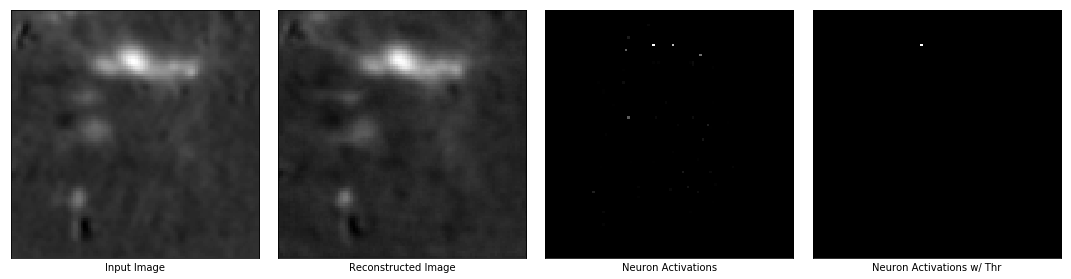

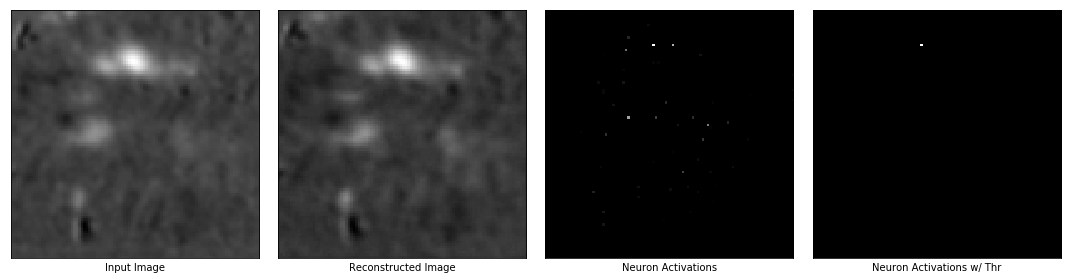

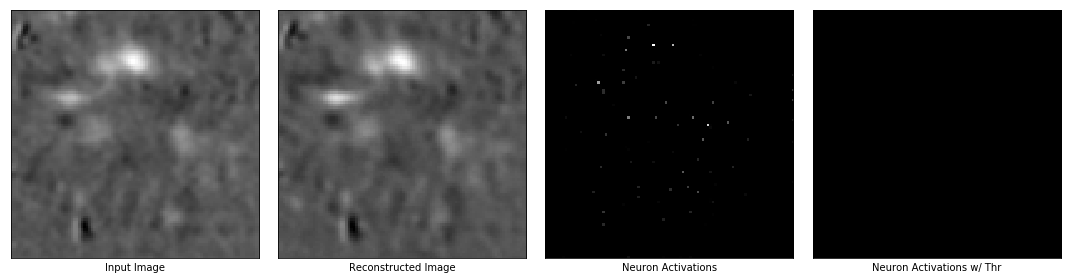

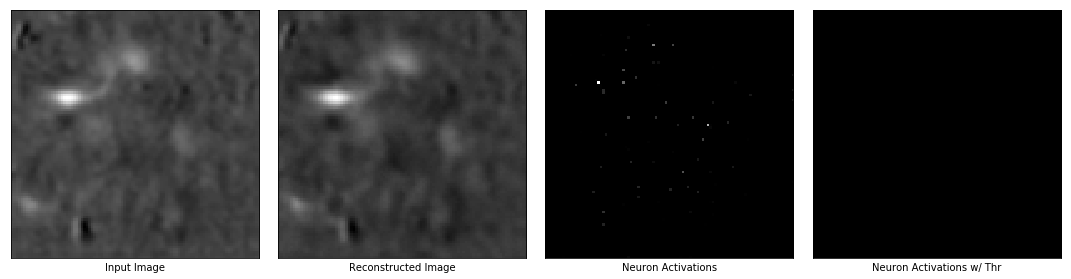

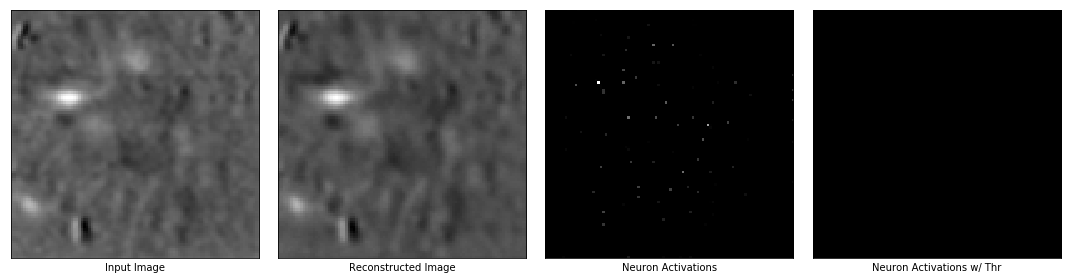

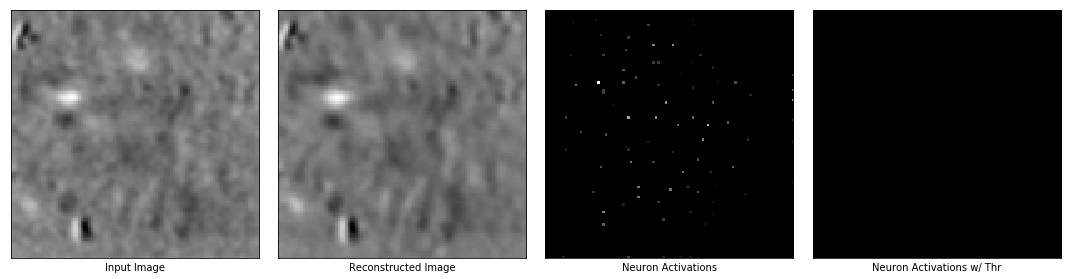

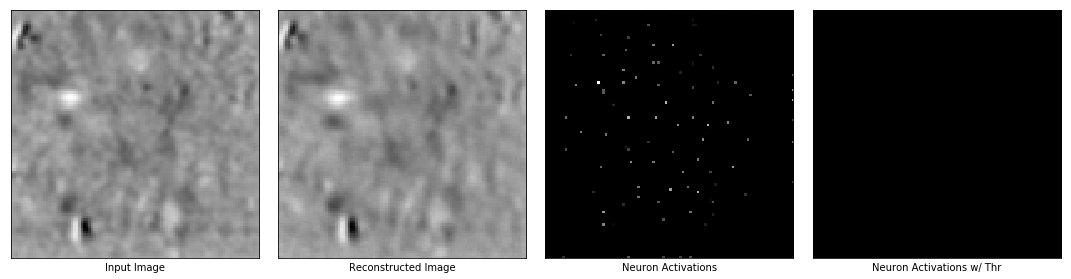

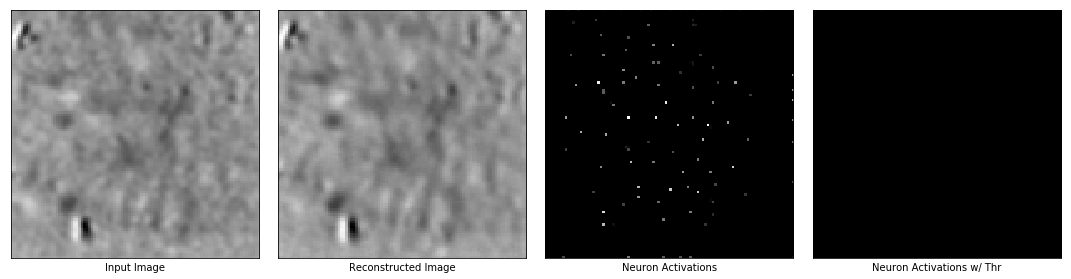

In [26]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

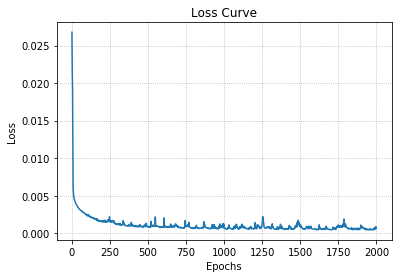

In [27]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [28]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [29]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_6
coord_conv_7
activation_2
up_sampling2d_7
conv2d_32
activation_3
conv2d_33


In [30]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


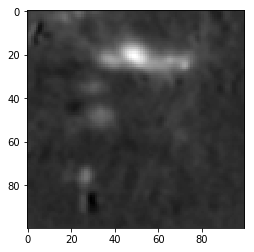

In [31]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


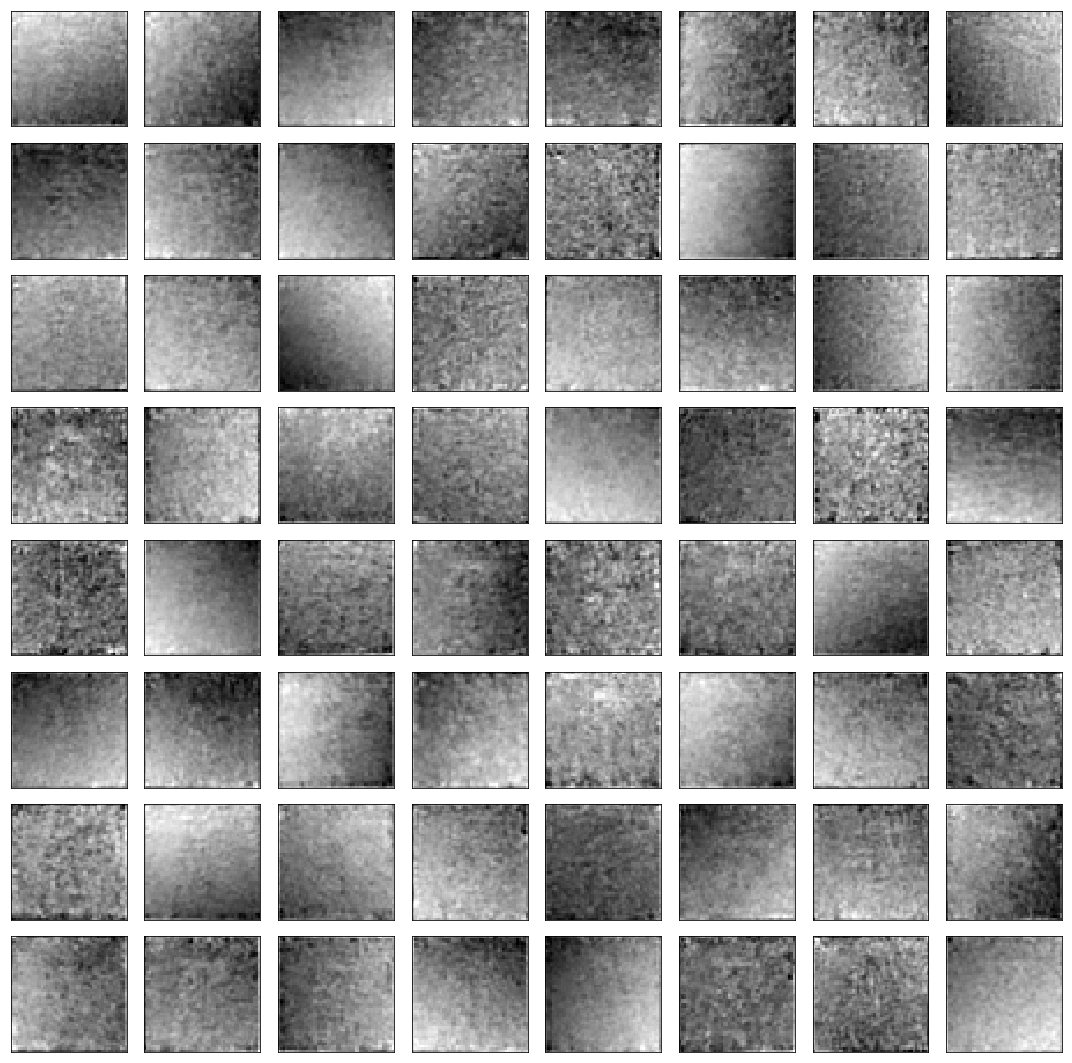

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


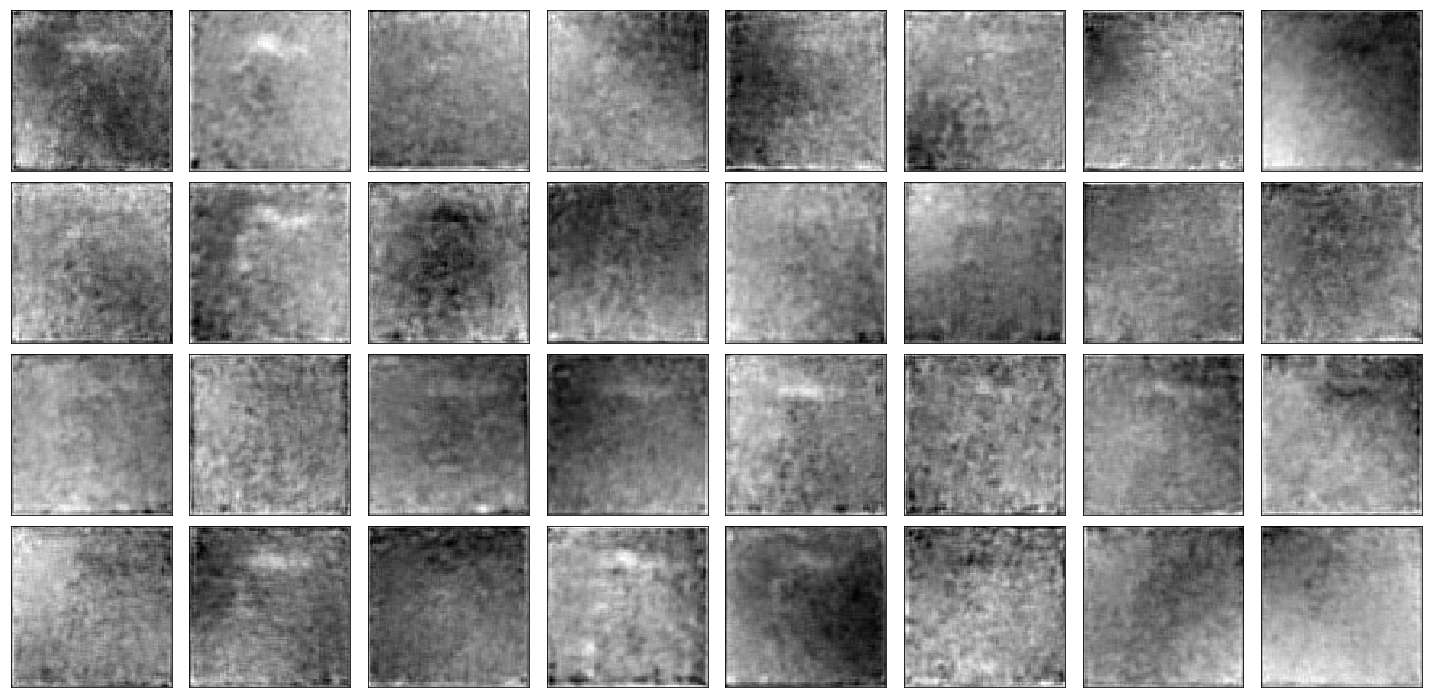

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

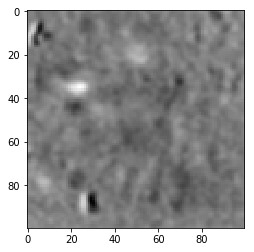

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


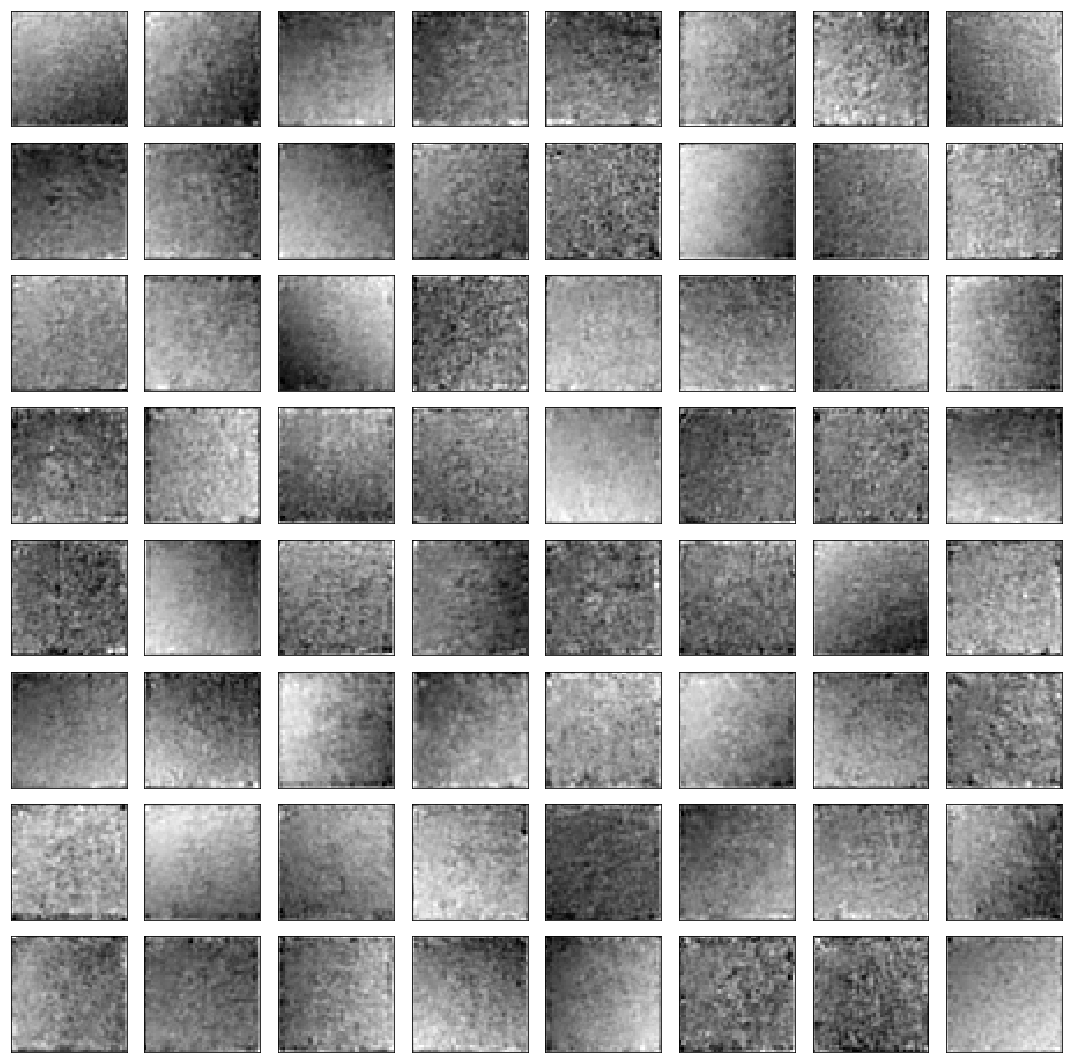

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


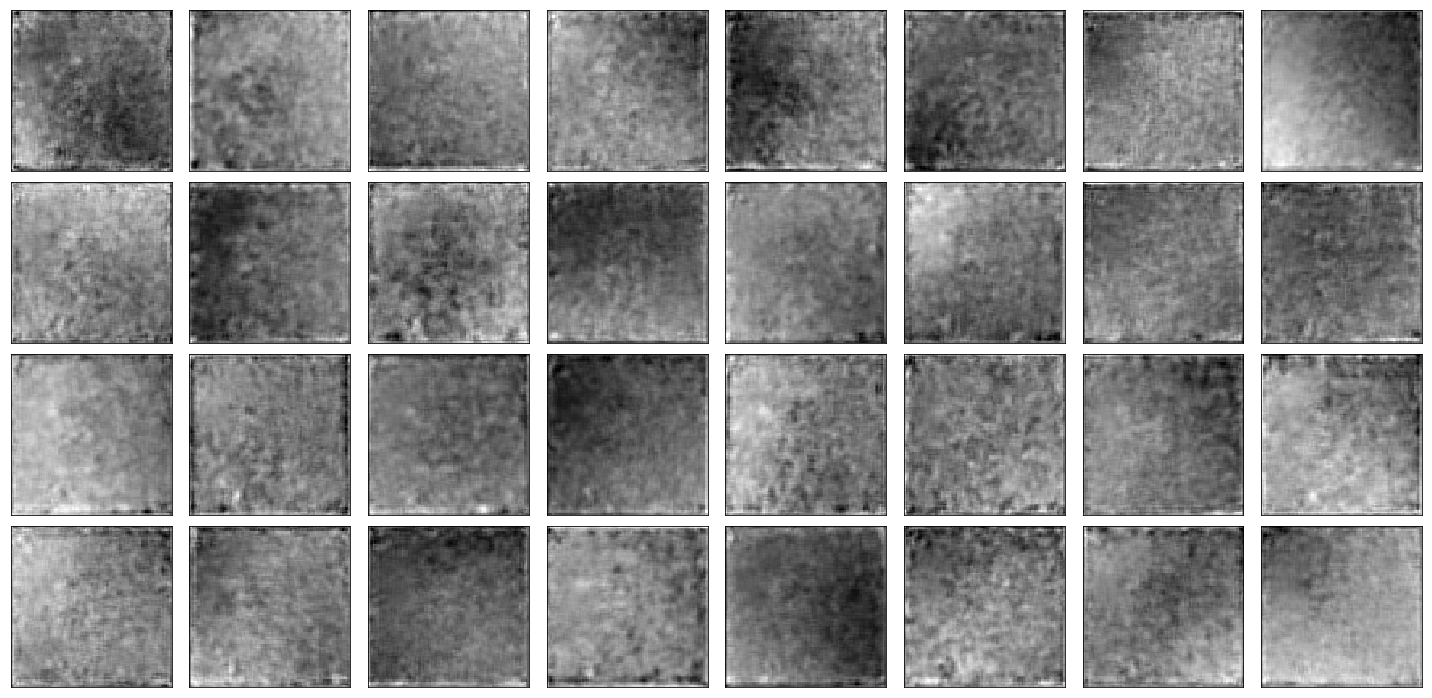

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

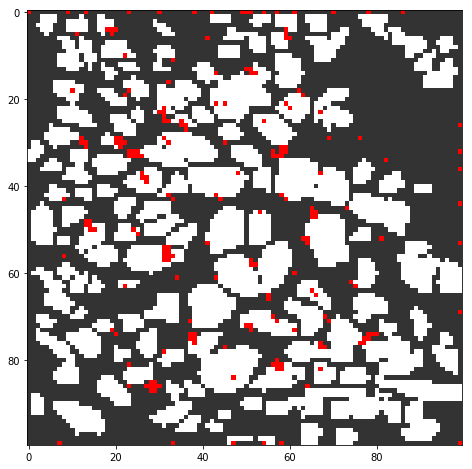

In [47]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

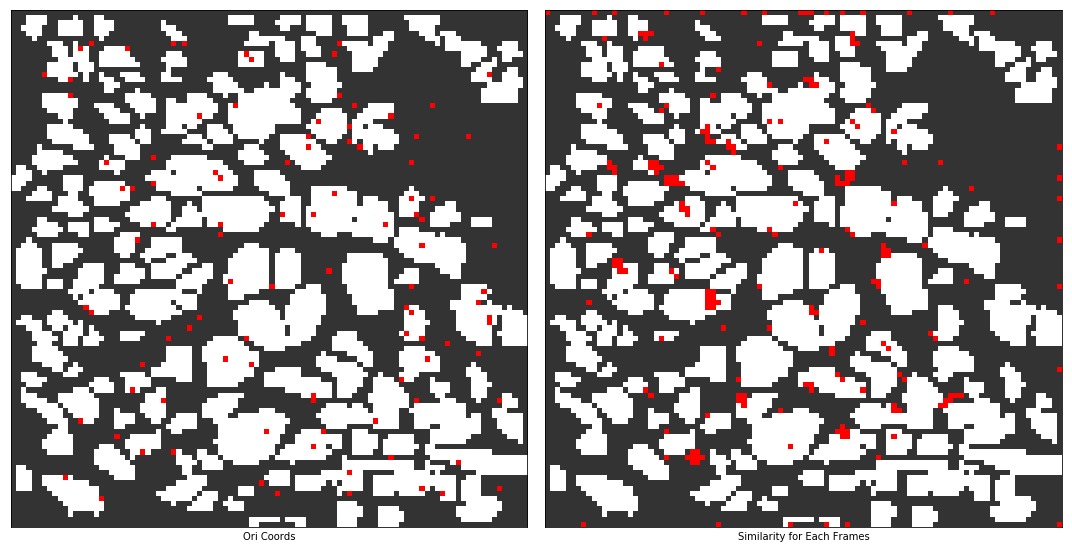

Counts:  201


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)